In [24]:
# Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
from scipy.interpolate import UnivariateSpline
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/naf/'
''' If SSL error _ssl.c:997: 
    pip install --upgrade certifi'''

tjy_udf:  ['CalcF', 'H_find', 'Heights', 'Kap_D', 'elread', 'get_fp', 'get_fs', 'git_sync', 'lighten_color', 'phread', 'phreadxyz', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


' If SSL error _ssl.c:997: \n    pip install --upgrade certifi'

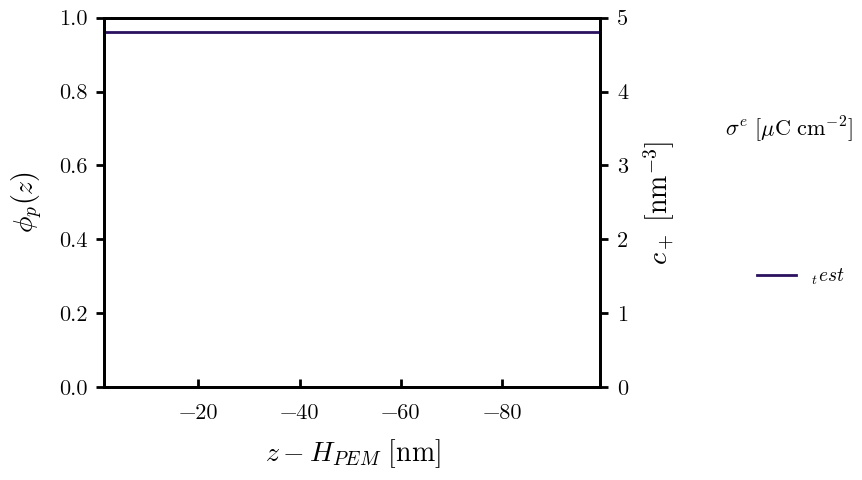

In [ ]:
mcs = mpl.colormaps['magma'].resampled(7)(range(5,0,-1))[::-1]
dz = 0.05 ## FIX PLOT SHIFTS IN CODE ITSELF, RIGHT NOW JUST GUESSING
Lz_PEM, phi_PEM = 199.4, 0.96
pat = 'ph'
eat = 'el'
fin = '.dat'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
# for i,c in zip(['10', '5', '0', 'n5', 'n10'],mcs):
for i,c in zip(['_test'],mcs):
    ph = tjy.phread(GIT+pat+i+fin, block=5)
    ax.plot(np.arange(-Lz_PEM,0.0001,0.1), [phi_PEM]*int(round(Lz_PEM/0.10)+1), c=c)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(i))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+fin)
    rax.plot(el.z-Lz_PEM+dz, el.ca,c=c, ls=':')
    
# ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
# ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z - H_{PEM}\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (-1.5, max(el.z)-Lz_PEM+2*dz),
    ylim= (0, 1),
)    
rax.set(
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (0, 5)
)
ax.text(1.38, 0.68, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.25), ncol=1)

tjy.ticks([ax, rax])

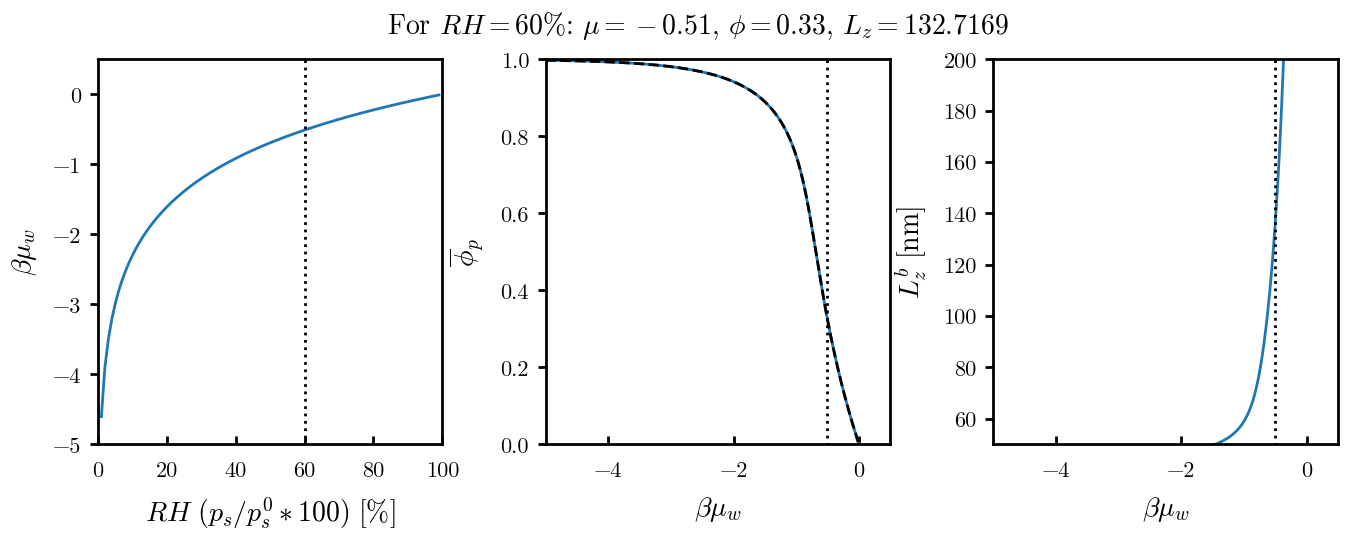

In [70]:
## Inputs
chi = 2.00
patm = 1.0 # ext. pressure = 1 atm

# Primary input
RH = 0.60

## Constants
nu = 0.069 #[nm3]
n_p, N, A  = 320, 100, 50 # [1], [1], [nm2]
kT = 1.38e-23 * 293 #[J]
p_kT = patm*101.3 / 1000 * (1e2/1e9)**3 / kT 

mukT_phi = lambda x: np.log(1-x) - x*(1-1/N) + chi*np.power(x,2) + p_kT*nu
mukT_P = lambda x: np.log(x)

fig, axs = plt.subplots(1,3, figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

Ps = np.arange(0.01, 1, 0.01)
axs[0].plot(Ps*100, mukT_P(Ps))

phis = np.arange(0.999,0.00,-0.001)
axs[1].plot(mukT_phi(phis), phis)
fit = UnivariateSpline(mukT_phi(phis), phis, s=1e-12)
mus = np.arange(-5, 0, 0.01)
axs[1].plot(mus, fit(mus),'--k')

axs[2].plot(mus, n_p*N*nu/fit(mus)/A)

mu = mukT_P(RH)
plt.suptitle(r'For $RH = {:.0f}$%: $\mu = {:.2f}$, $\phi = {:.2f}$, $L_z = {:.4f}$'.format(RH*100, mu, fit(mu), n_p*N*nu/fit(mu)/A), fontsize=20, fontfamily='serif')
axs[0].plot([RH*100]*2, [-100,100], ':k')
axs[1].plot([mu]*2, [-100,100], ':k')
axs[2].plot([mu]*2, [0,500], ':k')

axs[0].set(
    xlim= (0,100),
    ylim= (-5,0.5),
    xlabel=r'$RH\ (p_s/p_s^0*100)\ [\%]$',
    ylabel=r'$\beta\mu_w$',
)
axs[1].set(
    xlim= (-5,0.5),
    ylim= (0,1.0),
    xlabel=r'$\beta\mu_w$',
    ylabel=r'$\overline{\phi}_p$',
)
axs[2].set(
    xlim= (-5,0.5),
    ylim= (50, 200),
    ylabel=r'$L_z^b\ [\mathrm{nm}]$',
    xlabel=r'$\beta\mu_w$',
)
tjy.ticks(axs)

# Validations

## Surface charge

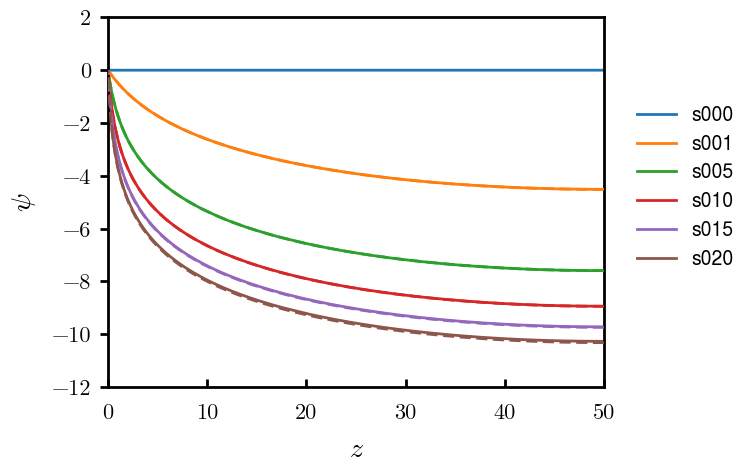

In [3]:
# Analytical, surface charge 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

L = 49.99
Cms = [0, 1.9241e-04, 2.1465e-04, 2.1772e-04, 2.1877e-04, 2.1931e-04] # Numerically found
fig, ax = plt.subplots(1,1)
for i,c,Cm in zip([0, 1,5,10,15,20], ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], Cms):
    surf_c = i*1e-20 # C/nm2
    if Cm != 0: 
        z = np.arange(0, L, 0.001)
        lam = np.sqrt(eps0*epsw / Cm)
        psi_h = lambda x: np.log( np.power(np.cos( x/lam/np.sqrt(2) ), 2) )
        ax.plot(L-z, -psi_h(z)+psi_h(L), c=c, zorder=5,ls=(0,(4,2)))

    ch = 'surf{0:02d}'.format(int(i))
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(L-el.z, el.psi-el.psi[len(el.psi)-1], c=c, label='s{:03d}'.format(i))

ax.set_xlim(0,50)
ax.set_xlabel(r'$z$')
ax.set_ylim(-12,2)
ax.set_ylabel(r'$\psi$')
ax.legend(loc=(1.05,0.3))
tjy.ticks()

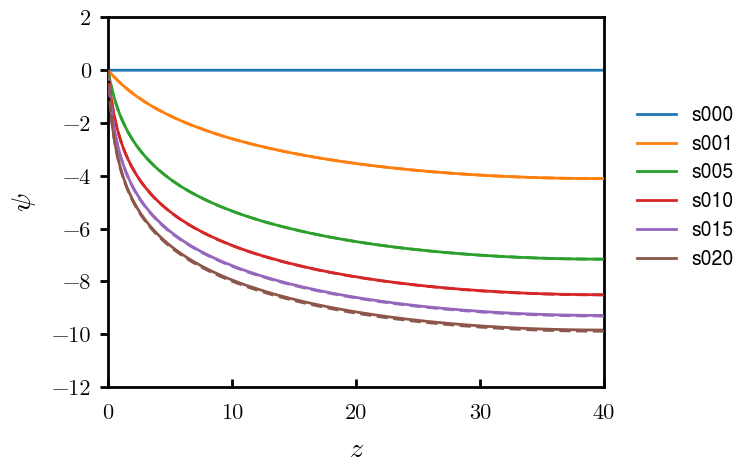

In [27]:
# Analytical, surface charge 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

L = 39.99
Cms = [0, 2.9099e-04, 3.3307e-04, 3.3902e-04, 3.4106e-04, 3.4210e-04] # Numerically found
fig, ax = plt.subplots(1,1)
for i,c,Cm in zip([0, 1,5,10,15,20], ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], Cms):
    surf_c = i*1e-20 # C/nm2
    if Cm != 0: 
        z = np.arange(0, L, 0.001)
        lam = np.sqrt(eps0*epsw / Cm)
        psi_h = lambda x: np.log( np.power(np.cos( x/lam/np.sqrt(2) ), 2) )
        ax.plot(L-z, -psi_h(z)+psi_h(L), c=c, zorder=5,ls=(0,(4,2)))

    ch = 'surf{0:02d}'.format(int(i))
    el = elread(GIT+'el_VALIDS_{:s}.dat'.format(ch))
    ax.plot(L-el.z, el.psi-el.psi[len(el.psi)-1], c=c, label='s{:03d}'.format(i))

ax.set_xlim(0,40)
ax.set_xlabel(r'$z$')
ax.set_ylim(-12,2)
ax.set_ylabel(r'$\psi$')
ax.legend(loc=(1.05,0.3))
tjy.ticks()

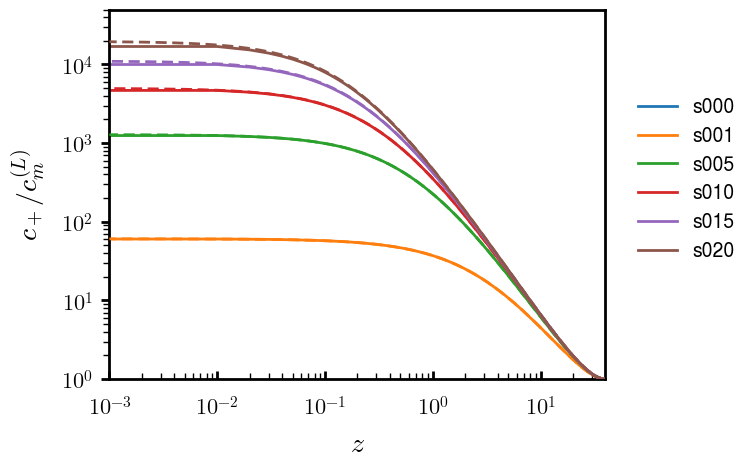

In [31]:
# Analytical, surface charge
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

L = 39.99
Cms = [0, 2.9099e-04, 3.3307e-04, 3.3902e-04, 3.4106e-04, 3.4210e-04] # Numerically found
fig, ax = plt.subplots(1,1)
for i,c,Cm in zip([0, 1,5,10,15,20], ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], Cms):
    surf_c = i*1e-20 # C/nm2
    if Cm != 0: 
        z = np.arange(0, L, 0.001)
        lam = np.sqrt(eps0*epsw / Cm)
        psi_h = lambda x: np.log( np.power(np.cos( x/lam/np.sqrt(2) ), 2) )
        ax.plot(L-z, np.exp(-psi_h(z)), c=c, zorder=5,ls=(0,(4,2)))
    else:  ax.plot(L-el.z, [0]*len(el.z),c=c)

    ch = 'surf{0:02d}'.format(int(i))
    el = elread(GIT+'el_VALIDS_{:s}.dat'.format(ch))
    ax.plot(L-el.z, el.ca/Cm, c=c, label='s{:03d}'.format(i))

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$c_+/c_m^{(L)}$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-03,L)
ax.set_ylim(1, 5e4)
ax.legend(loc=(1.05,0.3))
tjy.ticks()

## PEM extend

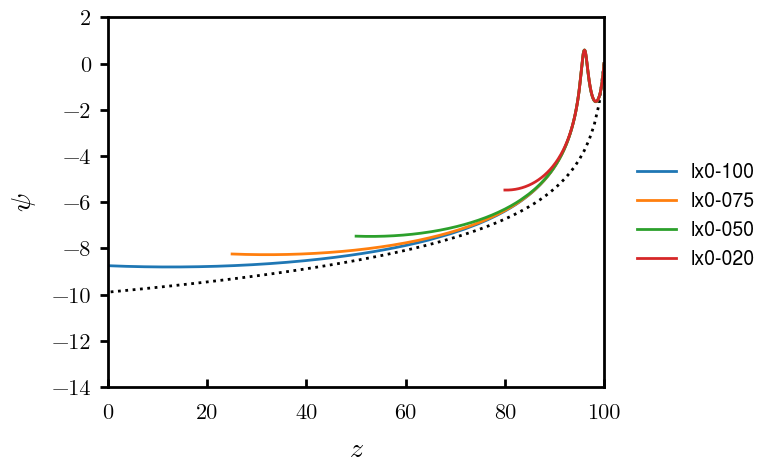

In [17]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

Ls = [20, 50, 75, 100][::-1]
surf_c = 5*1e-20 # C/nm2
fig, ax = plt.subplots(1,1)
for i,c in zip(Ls, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']):
    L = i-0.01
    ch = 'lx0-{0:03d}'.format(int(i))
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(el.z+(100-L), el.psi-el.psi[len(el.psi)-1], c=c, label='lx0-{:03d}'.format(i))
    
z = np.arange(0, 101)
lGC = 2*eps0*epsw/(surf_c/e)
ax.plot(100-z, -2*np.log(1+z/lGC), 'k:',zorder=1)

ax.set_xlim(0,100)
ax.set_xlabel(r'$z$')
ax.set_ylim(-14,2)
ax.set_ylabel(r'$\psi$')
ax.legend(loc=(1.05,0.3))
tjy.ticks()

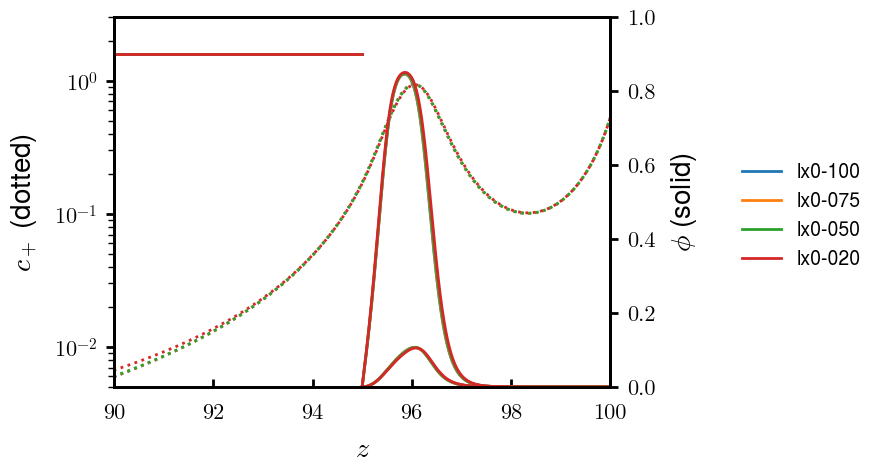

In [18]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

Ls = [20, 50, 75, 100][::-1]
surf_c = 10*1e-20 # C/nm2
fig, ax = plt.subplots(1,1)
rax = plt.twinx(ax)
for i,c in zip(Ls, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']):
    L = i-0.01

    ch = 'lx0-{0:03d}'.format(int(i))
    ph = tjy.phread(GIT+'ph_VALID_{:s}.dat'.format(ch), block=5)
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(el.z+(100-L), el.ca, c=c, ls=':')
    rax.plot([0,95], [0.9,0.9], c=c, label='lx0-{:03d}'.format(i))
    rax.plot(ph.z+95, ph.overall, c=c)
    rax.plot(ph.z+95, ph.block5, c=c)

ax.set(
    xlabel=r'$z$',
    ylabel=r'$c_+$ (dotted)',
    yscale='log',
    xlim = (90,100),
    ylim = (5e-03, 3)
)
rax.set(
    ylabel=r'$\phi$ (solid)',
    ylim=(0,1.0)
)
rax.legend(loc=(1.25,0.3))
tjy.ticks([ax,rax])

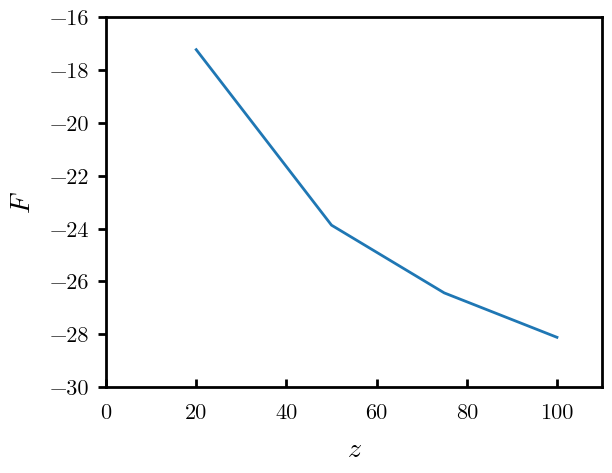

In [22]:
# FreeE(Lz)
plt.plot([20, 50,  75, 100], [-1.72219e+01, -2.38695e+01, -2.64353e+01, -2.81173e+01])

plt.ylabel(r'$F$')
plt.xlabel(r'$z$')
plt.xlim(0, 110)
plt.ylim(-30, -16)
tjy.ticks()

## Water extend

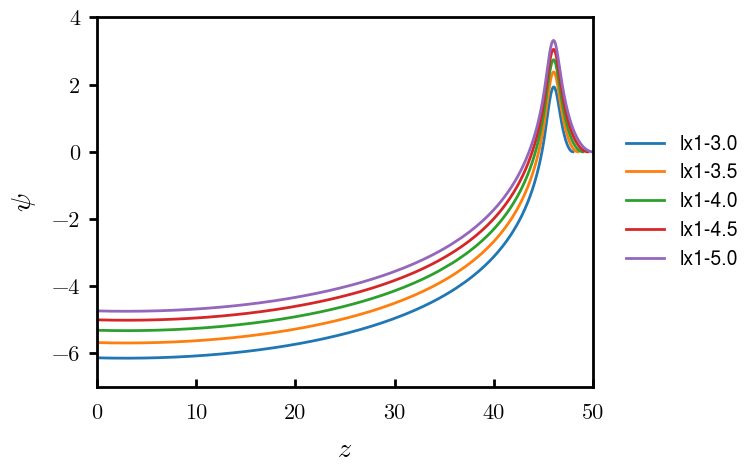

In [205]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

Ls = [3.0, 3.5, 4.0, 4.5, 5.0]
# surf_c = 10*1e-20 # C/nm2
fig, ax = plt.subplots(1,1)
for i,c,Cm in zip(Ls, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], Cms):
    L = i+5.0-0.01
    ch = 'lx1-{0:02d}'.format(int(i*10))
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c=c, label='lx1-{:.1f}'.format(i))
    
# z = np.arange(0, 201)
# lGC = 2*eps0*epsw/(surf_c/e)
# ax.plot(200-z, -2*np.log(1+z/lGC), 'k:',zorder=1)

ax.set_xlim(0,50)
ax.set_xlabel(r'$z$')
ax.set_ylim(-7,4)
ax.set_ylabel(r'$\psi$')
ax.legend(loc=(1.05,0.3))
tjy.ticks()

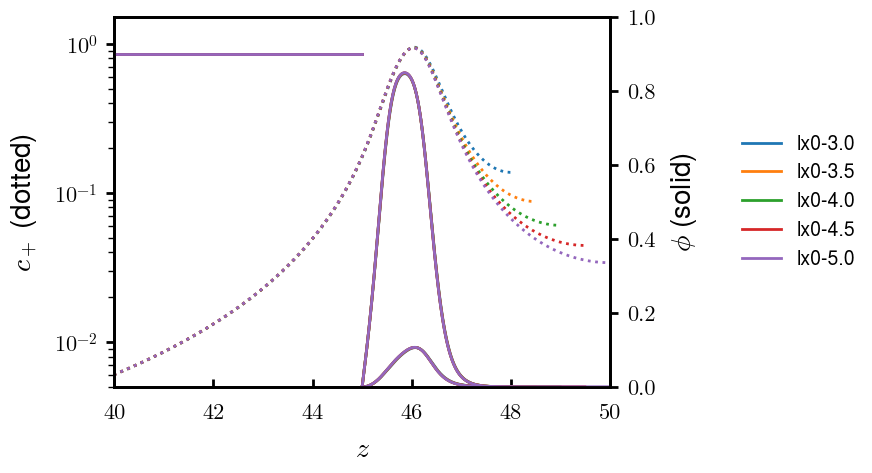

In [213]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

Ls = [3.0, 3.5, 4.0, 4.5, 5.0]
fig, ax = plt.subplots(1,1)
rax = plt.twinx(ax)
for i,c in zip(Ls, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']):
    ch = 'lx1-{0:02d}'.format(int(i*10))
    ph = tjy.phread(GIT+'ph_VALID_{:s}.dat'.format(ch), block=5)
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(el.z, el.ca, c=c, ls=':')
    rax.plot([0,45], [0.9,0.9], c=c, label='lx0-{:.1f}'.format(i))
    rax.plot(ph.z+45, ph.overall, c=c)
    rax.plot(ph.z+45, ph.block5, c=c)

ax.set(
    xlabel=r'$z$',
    ylabel=r'$c_+$ (dotted)',
    yscale='log',
    xlim = (40,50),
    ylim = (5e-03, 1.5)
)
rax.set(
    ylabel=r'$\phi$ (solid)',
    ylim=(0,1.0)
)
rax.legend(loc=(1.25,0.3))
tjy.ticks([ax,rax])

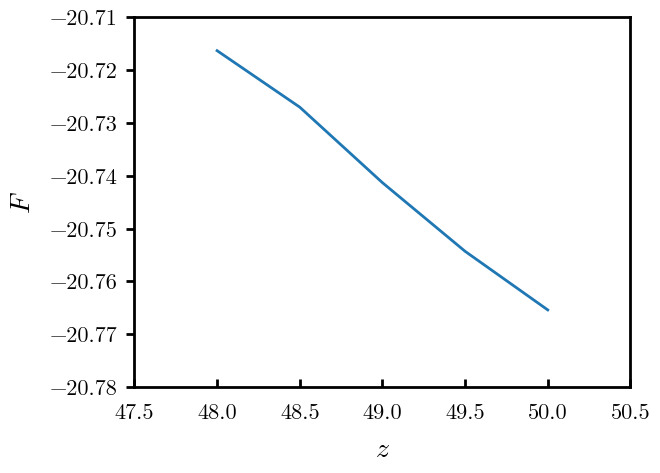

In [224]:
# FreeE(Lz)
plt.plot([48, 48.5, 49, 49.5, 50], [-2.07163e+01, -2.07270e+01, -2.07413e+01, -2.07543e+01, -2.07654e+01])

plt.ylabel(r'$F$')
plt.xlabel(r'$z$')
plt.xlim(47.5, 50.5)
plt.ylim(-20.78, -20.71)
tjy.ticks()

## PEM Charge Density

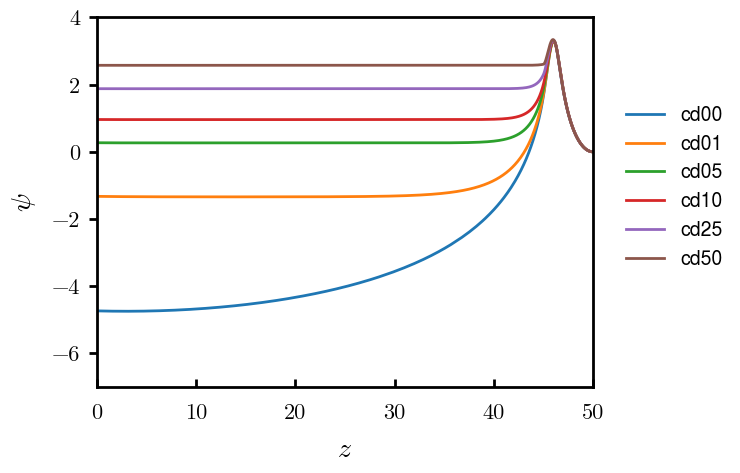

In [24]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

cds = [0, 1, 5, 10, 25, 50]
fig, ax = plt.subplots(1,1)
for i,c in zip(cds, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']):
    ch = 'cd{0:02d}'.format(int(i))
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c=c, label='cd{0:02d}'.format(i))

ax.set_xlim(0,50)
ax.set_xlabel(r'$z$')
ax.set_ylim(-7,4)
ax.set_ylabel(r'$\psi$')
ax.legend(loc=(1.05,0.3))
tjy.ticks()

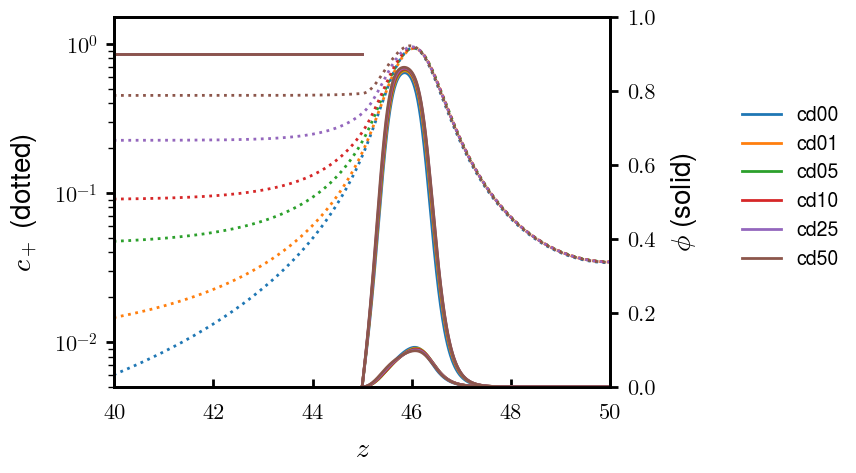

In [26]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

cds = [0,1,5,10,25,50]
fig, ax = plt.subplots(1,1)
rax = plt.twinx(ax)
for i,c in zip(cds, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']):
    ch = 'cd{0:02d}'.format(int(i))
    ph = tjy.phread(GIT+'ph_VALID_{:s}.dat'.format(ch), block=5)
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(el.z, el.ca, c=c, ls=':')
    rax.plot([0,45], [0.9,0.9], c=c, label='cd{0:02d}'.format(i))
    rax.plot(ph.z+45, ph.overall, c=c)
    rax.plot(ph.z+45, ph.block5, c=c)

ax.set(
    xlabel=r'$z$',
    ylabel=r'$c_+$ (dotted)',
    yscale='log',
    xlim = (40,50),
    ylim = (5e-03, 1.5)
)
rax.set(
    ylabel=r'$\phi$ (solid)',
    ylim=(0,1.0)
)
rax.legend(loc=(1.25,0.3))
tjy.ticks([ax,rax])

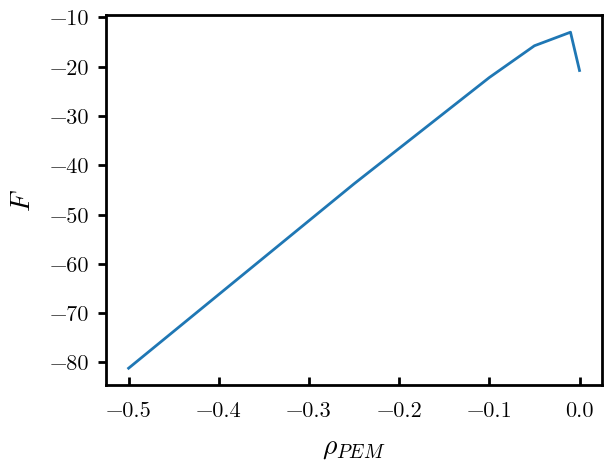

In [27]:
# FreeE(Lz)
plt.plot([-0.00, -0.01, -0.05, -0.10, -0.25, -0.50], [-2.07655e+01, -1.29976e+01, -1.57471e+01, -2.21910e+01, -4.37619e+01, -8.11806e+01])

plt.ylabel(r'$F$')
plt.xlabel(r'$\rho_{PEM}$')
# plt.xlim(47.5, 50.5)
# plt.ylim(-20.78, -20.71)
tjy.ticks()

## Sidechain grafting density

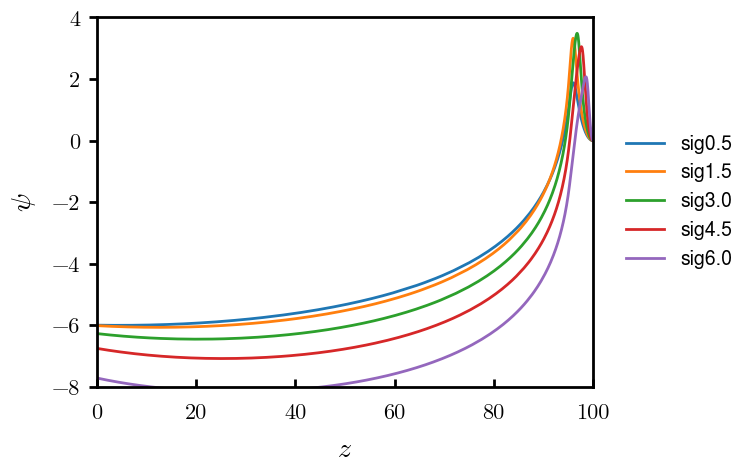

In [33]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

cds = [0.50, 1.50, 3.00, 4.50, 6.00]
fig, ax = plt.subplots(1,1)
for i,c in zip(cds, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']):
    L = i+5.0-0.01
    ch = 'sig{0:03d}'.format(int(i*100))
    el = elread(GIT+'el_VALIDS_{:s}.dat'.format(ch))
    ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c=c, label='sig{:.1f}'.format(i))
    
ax.set_xlim(0,100)
ax.set_xlabel(r'$z$')
ax.set_ylim(-8,4)
ax.set_ylabel(r'$\psi$')
ax.legend(loc=(1.05,0.3))
tjy.ticks()

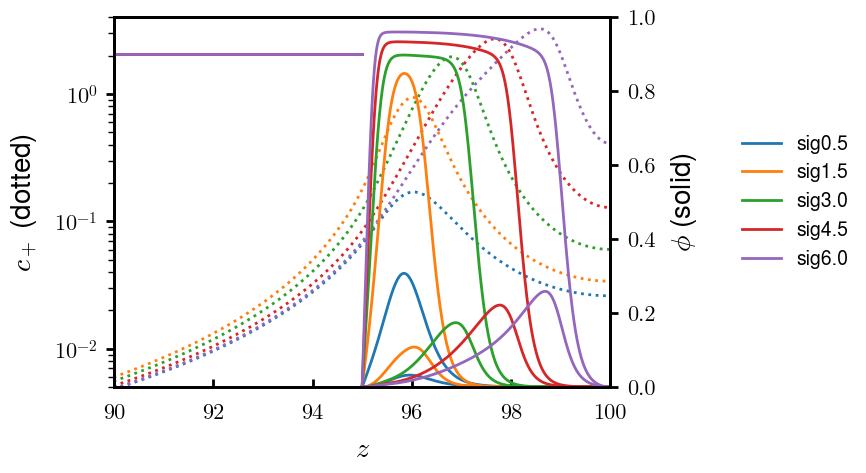

In [7]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

cds = [0.50, 1.50, 3.00, 4.50, 6.00]
fig, ax = plt.subplots(1,1)
rax = plt.twinx(ax)
for i,c in zip(cds, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']):
    ch = 'sig{0:03d}'.format(int(i*100))
    ph = tjy.phread(GIT+'ph_VALIDS_{:s}.dat'.format(ch), block=5)
    el = elread(GIT+'el_VALIDS_{:s}.dat'.format(ch))
    ax.plot(el.z, el.ca, c=c, ls=':')
    rax.plot([0,95], [0.9,0.9], c=c, label='sig{:.1f}'.format(i))
    rax.plot(ph.z+95, ph.overall, c=c)
    rax.plot(ph.z+95, ph.block5, c=c)

ax.set(
    xlabel=r'$z$',
    ylabel=r'$c_+$ (dotted)',
    yscale='log',
    xlim = (90,100),
    ylim = (5e-03, 4.0)
)
rax.set(
    ylabel=r'$\phi$ (solid)',
    ylim=(0,1.0)
)
rax.legend(loc=(1.25,0.3))
tjy.ticks([ax,rax])

## Mu / humidity

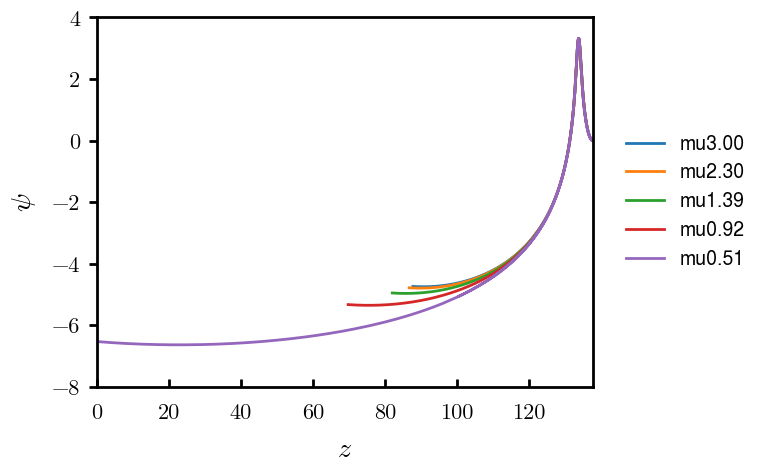

In [56]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

maxL = 137.8
cds = [3.00, 2.30, 1.39, 0.92, 0.51]
fig, ax = plt.subplots(1,1)
for i,c,Cm in zip(cds, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], Cms):
    ch = 'mu{0:03.0f}'.format(np.ceil(i*100))
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(el.z+maxL-max(el.z), el.psi-el.psi[len(el.psi)-1], c=c, label='mu{:.2f}'.format(i))
    
ax.set_xlim(0,137.8)
ax.set_xlabel(r'$z$')
ax.set_ylim(-8,4)
ax.set_ylabel(r'$\psi$')
ax.legend(loc=(1.05,0.3))
tjy.ticks()

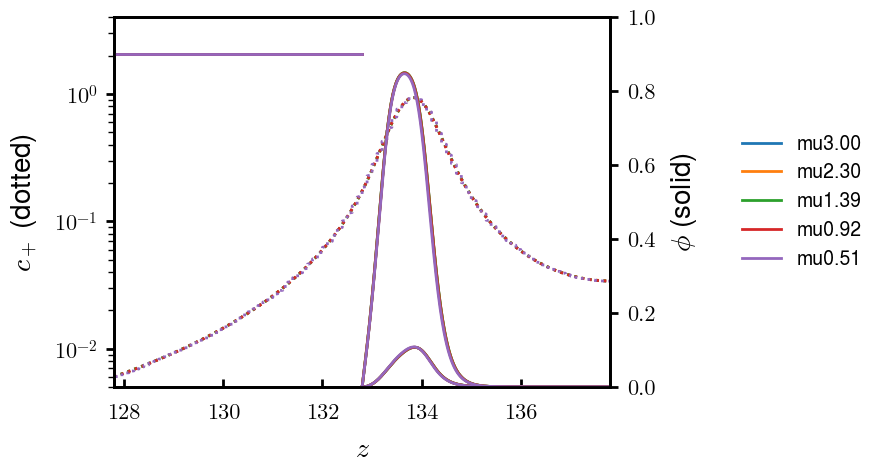

In [63]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

maxL = 137.8
cds = [3.00, 2.30, 1.39, 0.92, 0.51]
fig, ax = plt.subplots(1,1)
rax = plt.twinx(ax)
for i,c in zip(cds, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']):
    ch = 'mu{0:03.0f}'.format(np.ceil(i*100))
    ph = tjy.phread(GIT+'ph_VALID_{:s}.dat'.format(ch), block=5)
    el = elread(GIT+'el_VALID_{:s}.dat'.format(ch))
    ax.plot(el.z+maxL-max(el.z), el.ca, c=c, ls=':')
    rax.plot([0,maxL-5], [0.9,0.9], c=c, label='mu{:.2f}'.format(i))
    rax.plot(ph.z+maxL-5, ph.overall, c=c)
    rax.plot(ph.z+maxL-5, ph.block5, c=c)

ax.set(
    xlabel=r'$z$',
    ylabel=r'$c_+$ (dotted)',
    yscale='log',
    xlim = (maxL-10,maxL),
    ylim = (5e-03, 4.0)
)
rax.set(
    ylabel=r'$\phi$ (solid)',
    ylim=(0,1.0)
)
rax.legend(loc=(1.25,0.3))
tjy.ticks([ax,rax])

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 1.7457972013368075

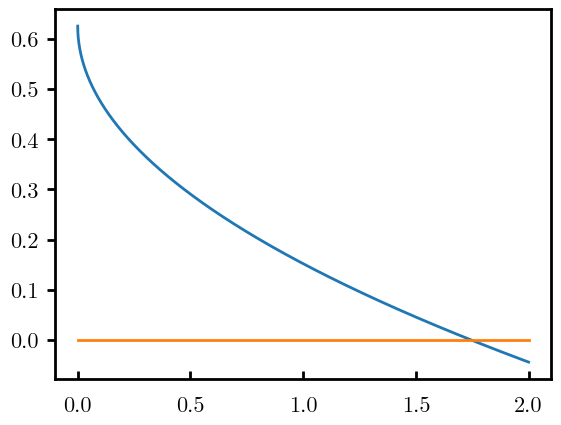

In [142]:
from scipy.optimize import root_scalar
eps = eps0*epsw
f = lambda x,h,c: -np.sqrt(2.0*eps*x)*np.tanh(h*np.sqrt(x/2.0/eps)) + c/e

plt.plot(np.arange(0,2,0.0001), f(np.arange(0,2,0.0001),50,10e-20))
plt.plot([0,2],[0,0])
tjy.ticks()

sol = root_scalar(f, args=(50, 10e-20), bracket=[1e-10, 1e2], method='brentq', rtol=1e-12, xtol=1e-12)
sol

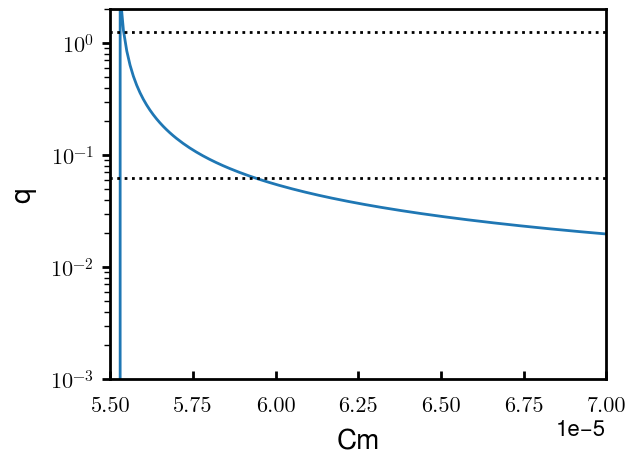

In [422]:
def qforward(Cm, h=200):
    eps = 0.11187582375000002 
    q = -1.0*np.sqrt(2.0*eps*Cm)*np.tan(h/2 * np.sqrt( Cm/2./eps ))
    return q

Cm = np.arange(0,20e-05,1e-07)
plt.plot(Cm, qforward(Cm))
plt.plot([0.00005, 0.00020], [1e-20/1.6e-19]*2,  ':k')
plt.plot([0.00005, 0.00020], [20e-20/1.6e-19]*2, ':k')

plt.xlim(5.5e-05,7e-05)
plt.yscale('log')
plt.ylim(1e-03,20e-01)

plt.xlabel('Cm')
plt.ylabel('q')
tjy.ticks()

4000


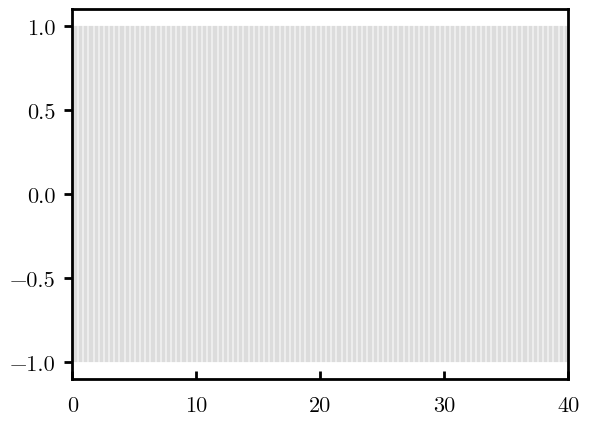

In [22]:
# for i in ['N50', 'N100', 'N250', 'N500', 'N1000']:
for i in ['surf01']:
    f,ax = plt.subplots(1,1)
    el = elread(GIT+'el_VALIDS_{:s}.dat'.format(i))
    step = 0
    for j in el.z: 
        if step%10 == 0: plt.plot([j,j], [-1,1], 'k', lw=0.1)
        step += 1
    print(len(el.z))
    plt.xlim(0,40)
    tjy.ticks()


In [23]:
# Converting wolfram cloud mesh to textfile
data = [0,0.00105006,0.00209989,0.0031495,0.00419887,0.00524802,0.00629693,0.00734562,0.00839408,0.00944231,0.0104903,0.0115381,0.0125856,0.013633,0.0146801,0.0157269,0.0167736,0.01782,0.0188662,0.0199121,0.0209579,0.0220034,0.0230487,0.0240937,0.0251386,0.0261832,0.0272275,0.0282717,0.0293156,0.0303593,0.0314028,0.0324461,0.0334891,0.034532,0.0355745,0.0366169,0.0376591,0.038701,0.0397427,0.0407842,0.0418254,0.0428665,0.0439073,0.0449479,0.0459882,0.0470284,0.0480683,0.049108,0.0501475,0.0511868,0.0522258,0.0532647,0.0543033,0.0553417,0.0563798,0.0574178,0.0584555,0.059493,0.0605303,0.0615674,0.0626042,0.0636409,0.0646773,0.0657135,0.0667495,0.0677853,0.0688208,0.0698561,0.0708913,0.0719262,0.0729608,0.0739953,0.0750296,0.0760636,0.0770974,0.078131,0.0791644,0.0801976,0.0812305,0.0822633,0.0832958,0.0843281,0.0853602,0.0863921,0.0874238,0.0884552,0.0894865,0.0905175,0.0915483,0.0925789,0.0936093,0.0946395,0.0956695,0.0966992,0.0977288,0.0987581,0.0997872,0.100816,0.101845,0.102873,0.103902,0.10493,0.105958,0.106985,0.108013,0.10904,0.110067,0.111094,0.11212,0.113147,0.114173,0.115199,0.116225,0.11725,0.118275,0.119301,0.120325,0.12135,0.122375,0.123399,0.124423,0.125447,0.126471,0.127494,0.128517,0.12954,0.130563,0.131586,0.132608,0.133631,0.134653,0.135674,0.136696,0.137717,0.138739,0.13976,0.140781,0.141801,0.142821,0.143842,0.144862,0.145881,0.146901,0.14792,0.14894,0.149959,0.150977,0.151996,0.153014,0.154032,0.15505,0.156068,0.157086,0.158103,0.15912,0.160137,0.161154,0.16217,0.163187,0.164203,0.165219,0.166235,0.16725,0.168265,0.169281,0.170295,0.17131,0.172325,0.173339,0.174353,0.175367,0.176381,0.177394,0.178408,0.179421,0.180434,0.181447,0.182459,0.183472,0.184484,0.185496,0.186508,0.187519,0.18853,0.189542,0.190553,0.191563,0.192574,0.193584,0.194595,0.195605,0.196614,0.197624,0.198634,0.199643,0.200652,0.201661,0.202669,0.203678,0.204686,0.205694,0.206702,0.20771,0.208717,0.209724,0.210731,0.211738,0.212745,0.213752,0.214758,0.215764,0.21677,0.217776,0.218781,0.219787,0.220792,0.221797,0.222802,0.223806,0.224811,0.225815,0.226819,0.227823,0.228826,0.22983,0.230833,0.231836,0.232839,0.233842,0.234844,0.235847,0.236849,0.237851,0.238853,0.239854,0.240856,0.241857,0.242858,0.243859,0.244859,0.24586,0.24686,0.24786,0.24886,0.24986,0.250859,0.251858,0.252858,0.253857,0.254855,0.255854,0.256852,0.25785,0.258849,0.259846,0.260844,0.261842,0.262839,0.263836,0.264833,0.26583,0.266826,0.267823,0.268819,0.269815,0.270811,0.271806,0.272802,0.273797,0.274792,0.275787,0.276782,0.277776,0.278771,0.279765,0.280759,0.281753,0.282746,0.28374,0.284733,0.285726,0.286719,0.287712,0.288704,0.289697,0.290689,0.291681,0.292673,0.293664,0.294656,0.295647,0.296638,0.297629,0.29862,0.29961,0.300601,0.301591,0.302581,0.303571,0.304561,0.30555,0.306539,0.307529,0.308518,0.309506,0.310495,0.311483,0.312472,0.31346,0.314448,0.315435,0.316423,0.31741,0.318398,0.319385,0.320371,0.321358,0.322345,0.323331,0.324317,0.325303,0.326289,0.327275,0.32826,0.329245,0.33023,0.331215,0.3322,0.333185,0.334169,0.335153,0.336137,0.337121,0.338105,0.339089,0.340072,0.341055,0.342038,0.343021,0.344004,0.344986,0.345969,0.346951,0.347933,0.348915,0.349896,0.350878,0.351859,0.35284,0.353821,0.354802,0.355783,0.356763,0.357744,0.358724,0.359704,0.360683,0.361663,0.362642,0.363622,0.364601,0.36558,0.366559,0.367537,0.368516,0.369494,0.370472,0.37145,0.372428,0.373405,0.374383,0.37536,0.376337,0.377314,0.378291,0.379267,0.380244,0.38122,0.382196,0.383172,0.384148,0.385123,0.386099,0.387074,0.388049,0.389024,0.389999,0.390974,0.391948,0.392922,0.393896,0.39487,0.395844,0.396818,0.397791,0.398765,0.399738,0.400711,0.401683,0.402656,0.403629,0.404601,0.405573,0.406545,0.407517,0.408489,0.40946,0.410431,0.411403,0.412374,0.413344,0.414315,0.415286,0.416256,0.417226,0.418196,0.419166,0.420136,0.421105,0.422075,0.423044,0.424013,0.424982,0.425951,0.426919,0.427888,0.428856,0.429824,0.430792,0.43176,0.432728,0.433695,0.434663,0.43563,0.436597,0.437564,0.43853,0.439497,0.440463,0.441429,0.442395,0.443361,0.444327,0.445293,0.446258,0.447223,0.448189,0.449153,0.450118,0.451083,0.452047,0.453012,0.453976,0.45494,0.455904,0.456868,0.457831,0.458795,0.459758,0.460721,0.461684,0.462647,0.463609,0.464572,0.465534,0.466496,0.467458,0.46842,0.469382,0.470343,0.471305,0.472266,0.473227,0.474188,0.475149,0.476109,0.47707,0.47803,0.47899,0.47995,0.48091,0.48187,0.48283,0.483789,0.484748,0.485707,0.486666,0.487625,0.488584,0.489542,0.490501,0.491459,0.492417,0.493375,0.494333,0.49529,0.496248,0.497205,0.498162,0.499119,0.500076,0.501033,0.501989,0.502946,0.503902,0.504858,0.505814,0.50677,0.507725,0.508681,0.509636,0.510592,0.511547,0.512502,0.513456,0.514411,0.515365,0.51632,0.517274,0.518228,0.519182,0.520136,0.521089,0.522043,0.522996,0.523949,0.524902,0.525855,0.526808,0.52776,0.528713,0.529665,0.530617,0.531569,0.532521,0.533473,0.534424,0.535376,0.536327,0.537278,0.538229,0.53918,0.540131,0.541081,0.542031,0.542982,0.543932,0.544882,0.545832,0.546781,0.547731,0.54868,0.54963,0.550579,0.551528,0.552476,0.553425,0.554374,0.555322,0.55627,0.557218,0.558166,0.559114,0.560062,0.561009,0.561957,0.562904,0.563851,0.564798,0.565745,0.566692,0.567638,0.568585,0.569531,0.570477,0.571423,0.572369,0.573315,0.57426,0.575206,0.576151,0.577096,0.578041,0.578986,0.579931,0.580876,0.58182,0.582764,0.583709,0.584653,0.585597,0.58654,0.587484,0.588427,0.589371,0.590314,0.591257,0.5922,0.593143,0.594086,0.595028,0.595971,0.596913,0.597855,0.598797,0.599739,0.60068,0.601622,0.602564,0.603505,0.604446,0.605387,0.606328,0.607269,0.608209,0.60915,0.61009,0.61103,0.611971,0.612911,0.61385,0.61479,0.61573,0.616669,0.617608,0.618547,0.619487,0.620425,0.621364,0.622303,0.623241,0.62418,0.625118,0.626056,0.626994,0.627932,0.628869,0.629807,0.630744,0.631682,0.632619,0.633556,0.634493,0.63543,0.636366,0.637303,0.638239,0.639175,0.640111,0.641047,0.641983,0.642919,0.643855,0.64479,0.645725,0.64666,0.647596,0.64853,0.649465,0.6504,0.651334,0.652269,0.653203,0.654137,0.655071,0.656005,0.656939,0.657873,0.658806,0.65974,0.660673,0.661606,0.662539,0.663472,0.664405,0.665337,0.66627,0.667202,0.668134,0.669066,0.669998,0.67093,0.671862,0.672793,0.673725,0.674656,0.675587,0.676519,0.677449,0.67838,0.679311,0.680242,0.681172,0.682102,0.683033,0.683963,0.684893,0.685822,0.686752,0.687682,0.688611,0.68954,0.69047,0.691399,0.692328,0.693256,0.694185,0.695114,0.696042,0.696971,0.697899,0.698827,0.699755,0.700683,0.70161,0.702538,0.703465,0.704393,0.70532,0.706247,0.707174,0.708101,0.709027,0.709954,0.710881,0.711807,0.712733,0.713659,0.714585,0.715511,0.716437,0.717362,0.718288,0.719213,0.720139,0.721064,0.721989,0.722914,0.723838,0.724763,0.725688,0.726612,0.727536,0.72846,0.729385,0.730308,0.731232,0.732156,0.73308,0.734003,0.734926,0.73585,0.736773,0.737696,0.738618,0.739541,0.740464,0.741386,0.742309,0.743231,0.744153,0.745075,0.745997,0.746919,0.74784,0.748762,0.749683,0.750605,0.751526,0.752447,0.753368,0.754289,0.75521,0.75613,0.757051,0.757971,0.758891,0.759811,0.760731,0.761651,0.762571,0.763491,0.76441,0.76533,0.766249,0.767168,0.768088,0.769006,0.769925,0.770844,0.771763,0.772681,0.7736,0.774518,0.775436,0.776354,0.777272,0.77819,0.779108,0.780025,0.780943,0.78186,0.782777,0.783695,0.784612,0.785529,0.786445,0.787362,0.788279,0.789195,0.790111,0.791028,0.791944,0.79286,0.793776,0.794692,0.795607,0.796523,0.797438,0.798354,0.799269,0.800184,0.801099,0.802014,0.802929,0.803843,0.804758,0.805672,0.806587,0.807501,0.808415,0.809329,0.810243,0.811157,0.81207,0.812984,0.813897,0.814811,0.815724,0.816637,0.81755,0.818463,0.819376,0.820288,0.821201,0.822113,0.823026,0.823938,0.82485,0.825762,0.826674,0.827586,0.828498,0.829409,0.830321,0.831232,0.832143,0.833055,0.833966,0.834877,0.835787,0.836698,0.837609,0.838519,0.83943,0.84034,0.84125,0.84216,0.84307,0.84398,0.84489,0.845799,0.846709,0.847618,0.848528,0.849437,0.850346,0.851255,0.852164,0.853073,0.853982,0.85489,0.855799,0.856707,0.857615,0.858524,0.859432,0.86034,0.861247,0.862155,0.863063,0.86397,0.864878,0.865785,0.866692,0.867599,0.868507,0.869413,0.87032,0.871227,0.872134,0.87304,0.873946,0.874853,0.875759,0.876665,0.877571,0.878477,0.879383,0.880288,0.881194,0.882099,0.883005,0.88391,0.884815,0.88572,0.886625,0.88753,0.888435,0.889339,0.890244,0.891148,0.892053,0.892957,0.893861,0.894765,0.895669,0.896573,0.897477,0.89838,0.899284,0.900187,0.901091,0.901994,0.902897,0.9038,0.904703,0.905606,0.906509,0.907411,0.908314,0.909216,0.910119,0.911021,0.911923,0.912825,0.913727,0.914629,0.915531,0.916432,0.917334,0.918235,0.919137,0.920038,0.920939,0.92184,0.922741,0.923642,0.924543,0.925443,0.926344,0.927244,0.928145,0.929045,0.929945,0.930845,0.931745,0.932645,0.933545,0.934444,0.935344,0.936244,0.937143,0.938042,0.938941,0.939841,0.94074,0.941638,0.942537,0.943436,0.944335,0.945233,0.946132,0.94703,0.947928,0.948826,0.949724,0.950622,0.95152,0.952418,0.953316,0.954213,0.955111,0.956008,0.956905,0.957803,0.9587,0.959597,0.960494,0.96139,0.962287,0.963184,0.96408,0.964977,0.965873,0.966769,0.967666,0.968562,0.969458,0.970354,0.971249,0.972145,0.973041,0.973936,0.974832,0.975727,0.976622,0.977517,0.978412,0.979307,0.980202,0.981097,0.981992,0.982886,0.983781,0.984675,0.985569,0.986464,0.987358,0.988252,0.989146,0.99004,0.990933,0.991827,0.992721,0.993614,0.994508,0.995401,0.996294,0.997187,0.99808,0.998973,0.999866,1.00076,1.00165,1.00254,1.00344,1.00433,1.00522,1.00611,1.00701,1.0079,1.00879,1.00968,1.01057,1.01147,1.01236,1.01325,1.01414,1.01503,1.01592,1.01681,1.0177,1.0186,1.01949,1.02038,1.02127,1.02216,1.02305,1.02394,1.02483,1.02572,1.02661,1.0275,1.02839,1.02928,1.03017,1.03106,1.03195,1.03284,1.03373,1.03462,1.03551,1.0364,1.03729,1.03818,1.03906,1.03995,1.04084,1.04173,1.04262,1.04351,1.0444,1.04529,1.04617,1.04706,1.04795,1.04884,1.04973,1.05061,1.0515,1.05239,1.05328,1.05416,1.05505,1.05594,1.05683,1.05771,1.0586,1.05949,1.06038,1.06126,1.06215,1.06304,1.06392,1.06481,1.0657,1.06658,1.06747,1.06835,1.06924,1.07013,1.07101,1.0719,1.07278,1.07367,1.07456,1.07544,1.07633,1.07721,1.0781,1.07898,1.07987,1.08075,1.08164,1.08252,1.08341,1.08429,1.08518,1.08606,1.08695,1.08783,1.08871,1.0896,1.09048,1.09137,1.09225,1.09313,1.09402,1.0949,1.09579,1.09667,1.09755,1.09844,1.09932,1.1002,1.10109,1.10197,1.10285,1.10374,1.10462,1.1055,1.10638,1.10727,1.10815,1.10903,1.10991,1.1108,1.11168,1.11256,1.11344,1.11433,1.11521,1.11609,1.11697,1.11785,1.11873,1.11962,1.1205,1.12138,1.12226,1.12314,1.12402,1.1249,1.12578,1.12667,1.12755,1.12843,1.12931,1.13019,1.13107,1.13195,1.13283,1.13371,1.13459,1.13547,1.13635,1.13723,1.13811,1.13899,1.13987,1.14075,1.14163,1.14251,1.14339,1.14427,1.14515,1.14603,1.14691,1.14778,1.14866,1.14954,1.15042,1.1513,1.15218,1.15306,1.15394,1.15482,1.15569,1.15657,1.15745,1.15833,1.15921,1.16008,1.16096,1.16184,1.16272,1.1636,1.16447,1.16535,1.16623,1.16711,1.16798,1.16886,1.16974,1.17062,1.17149,1.17237,1.17325,1.17412,1.175,1.17588,1.17675,1.17763,1.17851,1.17938,1.18026,1.18114,1.18201,1.18289,1.18376,1.18464,1.18552,1.18639,1.18727,1.18814,1.18902,1.1899,1.19077,1.19165,1.19252,1.1934,1.19427,1.19515,1.19602,1.1969,1.19777,1.19865,1.19952,1.2004,1.20127,1.20215,1.20302,1.2039,1.20477,1.20564,1.20652,1.20739,1.20827,1.20914,1.21002,1.21089,1.21176,1.21264,1.21351,1.21438,1.21526,1.21613,1.217,1.21788,1.21875,1.21962,1.2205,1.22137,1.22224,1.22312,1.22399,1.22486,1.22574,1.22661,1.22748,1.22835,1.22923,1.2301,1.23097,1.23184,1.23272,1.23359,1.23446,1.23533,1.2362,1.23708,1.23795,1.23882,1.23969,1.24056,1.24143,1.24231,1.24318,1.24405,1.24492,1.24579,1.24666,1.24753,1.2484,1.24928,1.25015,1.25102,1.25189,1.25276,1.25363,1.2545,1.25537,1.25624,1.25711,1.25798,1.25885,1.25972,1.26059,1.26146,1.26233,1.2632,1.26407,1.26494,1.26581,1.26668,1.26755,1.26842,1.26929,1.27016,1.27103,1.2719,1.27277,1.27364,1.27451,1.27537,1.27624,1.27711,1.27798,1.27885,1.27972,1.28059,1.28146,1.28233,1.28319,1.28406,1.28493,1.2858,1.28667,1.28754,1.2884,1.28927,1.29014,1.29101,1.29188,1.29274,1.29361,1.29448,1.29535,1.29621,1.29708,1.29795,1.29882,1.29968,1.30055,1.30142,1.30228,1.30315,1.30402,1.30489,1.30575,1.30662,1.30749,1.30835,1.30922,1.31009,1.31095,1.31182,1.31269,1.31355,1.31442,1.31529,1.31615,1.31702,1.31788,1.31875,1.31962,1.32048,1.32135,1.32221,1.32308,1.32394,1.32481,1.32568,1.32654,1.32741,1.32827,1.32914,1.33,1.33087,1.33173,1.3326,1.33346,1.33433,1.33519,1.33606,1.33692,1.33779,1.33865,1.33952,1.34038,1.34125,1.34211,1.34297,1.34384,1.3447,1.34557,1.34643,1.3473,1.34816,1.34902,1.34989,1.35075,1.35162,1.35248,1.35334,1.35421,1.35507,1.35593,1.3568,1.35766,1.35852,1.35939,1.36025,1.36111,1.36198,1.36284,1.3637,1.36457,1.36543,1.36629,1.36716,1.36802,1.36888,1.36974,1.37061,1.37147,1.37233,1.37319,1.37406,1.37492,1.37578,1.37664,1.37751,1.37837,1.37923,1.38009,1.38095,1.38182,1.38268,1.38354,1.3844,1.38526,1.38612,1.38699,1.38785,1.38871,1.38957,1.39043,1.39129,1.39215,1.39302,1.39388,1.39474,1.3956,1.39646,1.39732,1.39818,1.39904,1.3999,1.40076,1.40163,1.40249,1.40335,1.40421,1.40507,1.40593,1.40679,1.40765,1.40851,1.40937,1.41023,1.41109,1.41195,1.41281,1.41367,1.41453,1.41539,1.41625,1.41711,1.41797,1.41883,1.41969,1.42055,1.42141,1.42227,1.42313,1.42399,1.42485,1.42571,1.42656,1.42742,1.42828,1.42914,1.43,1.43086,1.43172,1.43258,1.43344,1.4343,1.43515,1.43601,1.43687,1.43773,1.43859,1.43945,1.44031,1.44117,1.44202,1.44288,1.44374,1.4446,1.44546,1.44631,1.44717,1.44803,1.44889,1.44975,1.45061,1.45146,1.45232,1.45318,1.45404,1.45489,1.45575,1.45661,1.45747,1.45832,1.45918,1.46004,1.4609,1.46175,1.46261,1.46347,1.46433,1.46518,1.46604,1.4669,1.46775,1.46861,1.46947,1.47032,1.47118,1.47204,1.4729,1.47375,1.47461,1.47547,1.47632,1.47718,1.47803,1.47889,1.47975,1.4806,1.48146,1.48232,1.48317,1.48403,1.48488,1.48574,1.4866,1.48745,1.48831,1.48916,1.49002,1.49088,1.49173,1.49259,1.49344,1.4943,1.49515,1.49601,1.49687,1.49772,1.49858,1.49943,1.50029,1.50114,1.502,1.50285,1.50371,1.50456,1.50542,1.50627,1.50713,1.50798,1.50884,1.50969,1.51055,1.5114,1.51226,1.51311,1.51397,1.51482,1.51568,1.51653,1.51739,1.51824,1.51909,1.51995,1.5208,1.52166,1.52251,1.52337,1.52422,1.52507,1.52593,1.52678,1.52764,1.52849,1.52934,1.5302,1.53105,1.53191,1.53276,1.53361,1.53447,1.53532,1.53617,1.53703,1.53788,1.53873,1.53959,1.54044,1.5413,1.54215,1.543,1.54385,1.54471,1.54556,1.54641,1.54727,1.54812,1.54897,1.54983,1.55068,1.55153,1.55239,1.55324,1.55409,1.55494,1.5558,1.55665,1.5575,1.55835,1.55921,1.56006,1.56091,1.56176,1.56262,1.56347,1.56432,1.56517,1.56603,1.56688,1.56773,1.56858,1.56944,1.57029,1.57114,1.57199,1.57284,1.5737,1.57455,1.5754,1.57625,1.5771,1.57795,1.57881,1.57966,1.58051,1.58136,1.58221,1.58306,1.58392,1.58477,1.58562,1.58647,1.58732,1.58817,1.58902,1.58988,1.59073,1.59158,1.59243,1.59328,1.59413,1.59498,1.59583,1.59668,1.59754,1.59839,1.59924,1.60009,1.60094,1.60179,1.60264,1.60349,1.60434,1.60519,1.60604,1.60689,1.60774,1.60859,1.60945,1.6103,1.61115,1.612,1.61285,1.6137,1.61455,1.6154,1.61625,1.6171,1.61795,1.6188,1.61965,1.6205,1.62135,1.6222,1.62305,1.6239,1.62475,1.6256,1.62645,1.6273,1.62815,1.629,1.62985,1.6307,1.63155,1.6324,1.63325,1.63409,1.63494,1.63579,1.63664,1.63749,1.63834,1.63919,1.64004,1.64089,1.64174,1.64259,1.64344,1.64429,1.64514,1.64599,1.64683,1.64768,1.64853,1.64938,1.65023,1.65108,1.65193,1.65278,1.65363,1.65447,1.65532,1.65617,1.65702,1.65787,1.65872,1.65957,1.66042,1.66126,1.66211,1.66296,1.66381,1.66466,1.66551,1.66636,1.6672,1.66805,1.6689,1.66975,1.6706,1.67145,1.67229,1.67314,1.67399,1.67484,1.67569,1.67653,1.67738,1.67823,1.67908,1.67993,1.68077,1.68162,1.68247,1.68332,1.68417,1.68501,1.68586,1.68671,1.68756,1.6884,1.68925,1.6901,1.69095,1.6918,1.69264,1.69349,1.69434,1.69519,1.69603,1.69688,1.69773,1.69857,1.69942,1.70027,1.70112,1.70196,1.70281,1.70366,1.70451,1.70535,1.7062,1.70705,1.70789,1.70874,1.70959,1.71044,1.71128,1.71213,1.71298,1.71382,1.71467,1.71552,1.71636,1.71721,1.71806,1.7189,1.71975,1.7206,1.72144,1.72229,1.72314,1.72398,1.72483,1.72568,1.72652,1.72737,1.72822,1.72906,1.72991,1.73076,1.7316,1.73245,1.7333,1.73414,1.73499,1.73584,1.73668,1.73753,1.73837,1.73922,1.74007,1.74091,1.74176,1.74261,1.74345,1.7443,1.74514,1.74599,1.74684,1.74768,1.74853,1.74937,1.75022,1.75107,1.75191,1.75276,1.7536,1.75445,1.75529,1.75614,1.75699,1.75783,1.75868,1.75952,1.76037,1.76121,1.76206,1.76291,1.76375,1.7646,1.76544,1.76629,1.76713,1.76798,1.76882,1.76967,1.77052,1.77136,1.77221,1.77305,1.7739,1.77474,1.77559,1.77643,1.77728,1.77812,1.77897,1.77981,1.78066,1.7815,1.78235,1.7832,1.78404,1.78489,1.78573,1.78658,1.78742,1.78827,1.78911,1.78996,1.7908,1.79165,1.79249,1.79334,1.79418,1.79503,1.79587,1.79672,1.79756,1.7984,1.79925,1.80009,1.80094,1.80178,1.80263,1.80347,1.80432,1.80516,1.80601,1.80685,1.8077,1.80854,1.80939,1.81023,1.81108,1.81192,1.81276,1.81361,1.81445,1.8153,1.81614,1.81699,1.81783,1.81868,1.81952,1.82036,1.82121,1.82205,1.8229,1.82374,1.82459,1.82543,1.82627,1.82712,1.82796,1.82881,1.82965,1.8305,1.83134,1.83218,1.83303,1.83387,1.83472,1.83556,1.83641,1.83725,1.83809,1.83894,1.83978,1.84063,1.84147,1.84231,1.84316,1.844,1.84485,1.84569,1.84653,1.84738,1.84822,1.84907,1.84991,1.85075,1.8516,1.85244,1.85328,1.85413,1.85497,1.85582,1.85666,1.8575,1.85835,1.85919,1.86003,1.86088,1.86172,1.86257,1.86341,1.86425,1.8651,1.86594,1.86678,1.86763,1.86847,1.86931,1.87016,1.871,1.87185,1.87269,1.87353,1.87438,1.87522,1.87606,1.87691,1.87775,1.87859,1.87944,1.88028,1.88112,1.88197,1.88281,1.88365,1.8845,1.88534,1.88618,1.88703,1.88787,1.88871,1.88956,1.8904,1.89124,1.89209,1.89293,1.89377,1.89462,1.89546,1.8963,1.89715,1.89799,1.89883,1.89968,1.90052,1.90136,1.90221,1.90305,1.90389,1.90474,1.90558,1.90642,1.90727,1.90811,1.90895,1.9098,1.91064,1.91148,1.91232,1.91317,1.91401,1.91485,1.9157,1.91654,1.91738,1.91823,1.91907,1.91991,1.92075,1.9216,1.92244,1.92328,1.92413,1.92497,1.92581,1.92666,1.9275,1.92834,1.92918,1.93003,1.93087,1.93171,1.93256,1.9334,1.93424,1.93508,1.93593,1.93677,1.93761,1.93846,1.9393,1.94014,1.94098,1.94183,1.94267,1.94351,1.94436,1.9452,1.94604,1.94688,1.94773,1.94857,1.94941,1.95026,1.9511,1.95194,1.95278,1.95363,1.95447,1.95531,1.95616,1.957,1.95784,1.95868,1.95953,1.96037,1.96121,1.96205,1.9629,1.96374,1.96458,1.96543,1.96627,1.96711,1.96795,1.9688,1.96964,1.97048,1.97132,1.97217,1.97301,1.97385,1.97469,1.97554,1.97638,1.97722,1.97807,1.97891,1.97975,1.98059,1.98144,1.98228,1.98312,1.98396,1.98481,1.98565,1.98649,1.98733,1.98818,1.98902,1.98986,1.9907,1.99155,1.99239,1.99323,1.99408,1.99492,1.99576,1.9966,1.99745,1.99829,1.99913,1.99997,2.00082,2.00166,2.0025,2.00334,2.00419,2.00503,2.00587,2.00671,2.00756,2.0084,2.00924,2.01008,2.01093,2.01177,2.01261,2.01346,2.0143,2.01514,2.01598,2.01683,2.01767,2.01851,2.01935,2.0202,2.02104,2.02188,2.02272,2.02357,2.02441,2.02525,2.02609,2.02694,2.02778,2.02862,2.02946,2.03031,2.03115,2.03199,2.03283,2.03368,2.03452,2.03536,2.03621,2.03705,2.03789,2.03873,2.03958,2.04042,2.04126,2.0421,2.04295,2.04379,2.04463,2.04547,2.04632,2.04716,2.048,2.04884,2.04969,2.05053,2.05137,2.05222,2.05306,2.0539,2.05474,2.05559,2.05643,2.05727,2.05811,2.05896,2.0598,2.06064,2.06149,2.06233,2.06317,2.06401,2.06486,2.0657,2.06654,2.06738,2.06823,2.06907,2.06991,2.07075,2.0716,2.07244,2.07328,2.07413,2.07497,2.07581,2.07665,2.0775,2.07834,2.07918,2.08003,2.08087,2.08171,2.08255,2.0834,2.08424,2.08508,2.08593,2.08677,2.08761,2.08845,2.0893,2.09014,2.09098,2.09183,2.09267,2.09351,2.09435,2.0952,2.09604,2.09688,2.09773,2.09857,2.09941,2.10025,2.1011,2.10194,2.10278,2.10363,2.10447,2.10531,2.10616,2.107,2.10784,2.10868,2.10953,2.11037,2.11121,2.11206,2.1129,2.11374,2.11459,2.11543,2.11627,2.11712,2.11796,2.1188,2.11964,2.12049,2.12133,2.12217,2.12302,2.12386,2.1247,2.12555,2.12639,2.12723,2.12808,2.12892,2.12976,2.13061,2.13145,2.13229,2.13314,2.13398,2.13482,2.13567,2.13651,2.13735,2.1382,2.13904,2.13988,2.14073,2.14157,2.14241,2.14326,2.1441,2.14494,2.14579,2.14663,2.14747,2.14832,2.14916,2.15,2.15085,2.15169,2.15253,2.15338,2.15422,2.15506,2.15591,2.15675,2.1576,2.15844,2.15928,2.16013,2.16097,2.16181,2.16266,2.1635,2.16434,2.16519,2.16603,2.16688,2.16772,2.16856,2.16941,2.17025,2.17109,2.17194,2.17278,2.17363,2.17447,2.17531,2.17616,2.177,2.17784,2.17869,2.17953,2.18038,2.18122,2.18206,2.18291,2.18375,2.1846,2.18544,2.18628,2.18713,2.18797,2.18882,2.18966,2.1905,2.19135,2.19219,2.19304,2.19388,2.19473,2.19557,2.19641,2.19726,2.1981,2.19895,2.19979,2.20063,2.20148,2.20232,2.20317,2.20401,2.20486,2.2057,2.20655,2.20739,2.20823,2.20908,2.20992,2.21077,2.21161,2.21246,2.2133,2.21415,2.21499,2.21583,2.21668,2.21752,2.21837,2.21921,2.22006,2.2209,2.22175,2.22259,2.22344,2.22428,2.22513,2.22597,2.22682,2.22766,2.2285,2.22935,2.23019,2.23104,2.23188,2.23273,2.23357,2.23442,2.23526,2.23611,2.23695,2.2378,2.23864,2.23949,2.24033,2.24118,2.24202,2.24287,2.24371,2.24456,2.2454,2.24625,2.24709,2.24794,2.24879,2.24963,2.25048,2.25132,2.25217,2.25301,2.25386,2.2547,2.25555,2.25639,2.25724,2.25808,2.25893,2.25978,2.26062,2.26147,2.26231,2.26316,2.264,2.26485,2.26569,2.26654,2.26739,2.26823,2.26908,2.26992,2.27077,2.27161,2.27246,2.27331,2.27415,2.275,2.27584,2.27669,2.27754,2.27838,2.27923,2.28007,2.28092,2.28177,2.28261,2.28346,2.2843,2.28515,2.286,2.28684,2.28769,2.28853,2.28938,2.29023,2.29107,2.29192,2.29277,2.29361,2.29446,2.29531,2.29615,2.297,2.29784,2.29869,2.29954,2.30038,2.30123,2.30208,2.30292,2.30377,2.30462,2.30546,2.30631,2.30716,2.308,2.30885,2.3097,2.31054,2.31139,2.31224,2.31308,2.31393,2.31478,2.31563,2.31647,2.31732,2.31817,2.31901,2.31986,2.32071,2.32156,2.3224,2.32325,2.3241,2.32494,2.32579,2.32664,2.32749,2.32833,2.32918,2.33003,2.33088,2.33172,2.33257,2.33342,2.33427,2.33511,2.33596,2.33681,2.33766,2.3385,2.33935,2.3402,2.34105,2.34189,2.34274,2.34359,2.34444,2.34529,2.34613,2.34698,2.34783,2.34868,2.34953,2.35037,2.35122,2.35207,2.35292,2.35377,2.35461,2.35546,2.35631,2.35716,2.35801,2.35886,2.3597,2.36055,2.3614,2.36225,2.3631,2.36395,2.36479,2.36564,2.36649,2.36734,2.36819,2.36904,2.36989,2.37074,2.37158,2.37243,2.37328,2.37413,2.37498,2.37583,2.37668,2.37753,2.37837,2.37922,2.38007,2.38092,2.38177,2.38262,2.38347,2.38432,2.38517,2.38602,2.38687,2.38772,2.38857,2.38941,2.39026,2.39111,2.39196,2.39281,2.39366,2.39451,2.39536,2.39621,2.39706,2.39791,2.39876,2.39961,2.40046,2.40131,2.40216,2.40301,2.40386,2.40471,2.40556,2.40641,2.40726,2.40811,2.40896,2.40981,2.41066,2.41151,2.41236,2.41321,2.41406,2.41491,2.41576,2.41661,2.41746,2.41831,2.41916,2.42001,2.42086,2.42171,2.42257,2.42342,2.42427,2.42512,2.42597,2.42682,2.42767,2.42852,2.42937,2.43022,2.43107,2.43192,2.43278,2.43363,2.43448,2.43533,2.43618,2.43703,2.43788,2.43873,2.43959,2.44044,2.44129,2.44214,2.44299,2.44384,2.44469,2.44555,2.4464,2.44725,2.4481,2.44895,2.4498,2.45066,2.45151,2.45236,2.45321,2.45406,2.45491,2.45577,2.45662,2.45747,2.45832,2.45918,2.46003,2.46088,2.46173,2.46258,2.46344,2.46429,2.46514,2.46599,2.46685,2.4677,2.46855,2.4694,2.47026,2.47111,2.47196,2.47281,2.47367,2.47452,2.47537,2.47623,2.47708,2.47793,2.47879,2.47964,2.48049,2.48134,2.4822,2.48305,2.4839,2.48476,2.48561,2.48646,2.48732,2.48817,2.48902,2.48988,2.49073,2.49158,2.49244,2.49329,2.49415,2.495,2.49585,2.49671,2.49756,2.49842,2.49927,2.50012,2.50098,2.50183,2.50269,2.50354,2.50439,2.50525,2.5061,2.50696,2.50781,2.50867,2.50952,2.51037,2.51123,2.51208,2.51294,2.51379,2.51465,2.5155,2.51636,2.51721,2.51807,2.51892,2.51978,2.52063,2.52149,2.52234,2.5232,2.52405,2.52491,2.52576,2.52662,2.52747,2.52833,2.52918,2.53004,2.53089,2.53175,2.53261,2.53346,2.53432,2.53517,2.53603,2.53688,2.53774,2.5386,2.53945,2.54031,2.54116,2.54202,2.54288,2.54373,2.54459,2.54544,2.5463,2.54716,2.54801,2.54887,2.54973,2.55058,2.55144,2.5523,2.55315,2.55401,2.55487,2.55572,2.55658,2.55744,2.55829,2.55915,2.56001,2.56086,2.56172,2.56258,2.56344,2.56429,2.56515,2.56601,2.56686,2.56772,2.56858,2.56944,2.57029,2.57115,2.57201,2.57287,2.57373,2.57458,2.57544,2.5763,2.57716,2.57801,2.57887,2.57973,2.58059,2.58145,2.5823,2.58316,2.58402,2.58488,2.58574,2.5866,2.58746,2.58831,2.58917,2.59003,2.59089,2.59175,2.59261,2.59347,2.59432,2.59518,2.59604,2.5969,2.59776,2.59862,2.59948,2.60034,2.6012,2.60206,2.60292,2.60378,2.60463,2.60549,2.60635,2.60721,2.60807,2.60893,2.60979,2.61065,2.61151,2.61237,2.61323,2.61409,2.61495,2.61581,2.61667,2.61753,2.61839,2.61925,2.62011,2.62097,2.62183,2.6227,2.62356,2.62442,2.62528,2.62614,2.627,2.62786,2.62872,2.62958,2.63044,2.6313,2.63216,2.63303,2.63389,2.63475,2.63561,2.63647,2.63733,2.63819,2.63905,2.63992,2.64078,2.64164,2.6425,2.64336,2.64422,2.64509,2.64595,2.64681,2.64767,2.64853,2.6494,2.65026,2.65112,2.65198,2.65285,2.65371,2.65457,2.65543,2.6563,2.65716,2.65802,2.65888,2.65975,2.66061,2.66147,2.66233,2.6632,2.66406,2.66492,2.66579,2.66665,2.66751,2.66838,2.66924,2.6701,2.67097,2.67183,2.67269,2.67356,2.67442,2.67529,2.67615,2.67701,2.67788,2.67874,2.67961,2.68047,2.68133,2.6822,2.68306,2.68393,2.68479,2.68566,2.68652,2.68738,2.68825,2.68911,2.68998,2.69084,2.69171,2.69257,2.69344,2.6943,2.69517,2.69603,2.6969,2.69776,2.69863,2.69949,2.70036,2.70122,2.70209,2.70296,2.70382,2.70469,2.70555,2.70642,2.70728,2.70815,2.70902,2.70988,2.71075,2.71161,2.71248,2.71335,2.71421,2.71508,2.71595,2.71681,2.71768,2.71855,2.71941,2.72028,2.72115,2.72201,2.72288,2.72375,2.72461,2.72548,2.72635,2.72722,2.72808,2.72895,2.72982,2.73069,2.73155,2.73242,2.73329,2.73416,2.73502,2.73589,2.73676,2.73763,2.7385,2.73936,2.74023,2.7411,2.74197,2.74284,2.74371,2.74457,2.74544,2.74631,2.74718,2.74805,2.74892,2.74979,2.75065,2.75152,2.75239,2.75326,2.75413,2.755,2.75587,2.75674,2.75761,2.75848,2.75935,2.76022,2.76109,2.76196,2.76283,2.7637,2.76457,2.76544,2.76631,2.76718,2.76805,2.76892,2.76979,2.77066,2.77153,2.7724,2.77327,2.77414,2.77501,2.77588,2.77675,2.77762,2.77849,2.77936,2.78024,2.78111,2.78198,2.78285,2.78372,2.78459,2.78546,2.78633,2.78721,2.78808,2.78895,2.78982,2.79069,2.79157,2.79244,2.79331,2.79418,2.79505,2.79593,2.7968,2.79767,2.79854,2.79942,2.80029,2.80116,2.80203,2.80291,2.80378,2.80465,2.80553,2.8064,2.80727,2.80815,2.80902,2.80989,2.81077,2.81164,2.81251,2.81339,2.81426,2.81513,2.81601,2.81688,2.81776,2.81863,2.8195,2.82038,2.82125,2.82213,2.823,2.82387,2.82475,2.82562,2.8265,2.82737,2.82825,2.82912,2.83,2.83087,2.83175,2.83262,2.8335,2.83437,2.83525,2.83612,2.837,2.83788,2.83875,2.83963,2.8405,2.84138,2.84225,2.84313,2.84401,2.84488,2.84576,2.84664,2.84751,2.84839,2.84926,2.85014,2.85102,2.85189,2.85277,2.85365,2.85453,2.8554,2.85628,2.85716,2.85803,2.85891,2.85979,2.86067,2.86154,2.86242,2.8633,2.86418,2.86505,2.86593,2.86681,2.86769,2.86857,2.86944,2.87032,2.8712,2.87208,2.87296,2.87384,2.87471,2.87559,2.87647,2.87735,2.87823,2.87911,2.87999,2.88087,2.88175,2.88263,2.88351,2.88438,2.88526,2.88614,2.88702,2.8879,2.88878,2.88966,2.89054,2.89142,2.8923,2.89318,2.89406,2.89494,2.89582,2.89671,2.89759,2.89847,2.89935,2.90023,2.90111,2.90199,2.90287,2.90375,2.90463,2.90551,2.9064,2.90728,2.90816,2.90904,2.90992,2.9108,2.91169,2.91257,2.91345,2.91433,2.91521,2.9161,2.91698,2.91786,2.91874,2.91963,2.92051,2.92139,2.92227,2.92316,2.92404,2.92492,2.92581,2.92669,2.92757,2.92846,2.92934,2.93022,2.93111,2.93199,2.93287,2.93376,2.93464,2.93553,2.93641,2.93729,2.93818,2.93906,2.93995,2.94083,2.94172,2.9426,2.94348,2.94437,2.94525,2.94614,2.94702,2.94791,2.94879,2.94968,2.95057,2.95145,2.95234,2.95322,2.95411,2.95499,2.95588,2.95676,2.95765,2.95854,2.95942,2.96031,2.9612,2.96208,2.96297,2.96386,2.96474,2.96563,2.96652,2.9674,2.96829,2.96918,2.97006,2.97095,2.97184,2.97273,2.97361,2.9745,2.97539,2.97628,2.97716,2.97805,2.97894,2.97983,2.98072,2.9816,2.98249,2.98338,2.98427,2.98516,2.98605,2.98694,2.98783,2.98871,2.9896,2.99049,2.99138,2.99227,2.99316,2.99405,2.99494,2.99583,2.99672,2.99761,2.9985,2.99939,3.00028,3.00117,3.00206,3.00295,3.00384,3.00473,3.00562,3.00651,3.0074,3.00829,3.00918,3.01008,3.01097,3.01186,3.01275,3.01364,3.01453,3.01542,3.01631,3.01721,3.0181,3.01899,3.01988,3.02077,3.02167,3.02256,3.02345,3.02434,3.02524,3.02613,3.02702,3.02791,3.02881,3.0297,3.03059,3.03149,3.03238,3.03327,3.03417,3.03506,3.03595,3.03685,3.03774,3.03864,3.03953,3.04042,3.04132,3.04221,3.04311,3.044,3.0449,3.04579,3.04668,3.04758,3.04847,3.04937,3.05026,3.05116,3.05206,3.05295,3.05385,3.05474,3.05564,3.05653,3.05743,3.05832,3.05922,3.06012,3.06101,3.06191,3.06281,3.0637,3.0646,3.0655,3.06639,3.06729,3.06819,3.06908,3.06998,3.07088,3.07178,3.07267,3.07357,3.07447,3.07537,3.07626,3.07716,3.07806,3.07896,3.07986,3.08075,3.08165,3.08255,3.08345,3.08435,3.08525,3.08615,3.08704,3.08794,3.08884,3.08974,3.09064,3.09154,3.09244,3.09334,3.09424,3.09514,3.09604,3.09694,3.09784,3.09874,3.09964,3.10054,3.10144,3.10234,3.10324,3.10414,3.10504,3.10595,3.10685,3.10775,3.10865,3.10955,3.11045,3.11135,3.11226,3.11316,3.11406,3.11496,3.11586,3.11677,3.11767,3.11857,3.11947,3.12038,3.12128,3.12218,3.12308,3.12399,3.12489,3.12579,3.1267,3.1276,3.1285,3.12941,3.13031,3.13121,3.13212,3.13302,3.13393,3.13483,3.13573,3.13664,3.13754,3.13845,3.13935,3.14026,3.14116,3.14207,3.14297,3.14388,3.14478,3.14569,3.14659,3.1475,3.14841,3.14931,3.15022,3.15112,3.15203,3.15294,3.15384,3.15475,3.15565,3.15656,3.15747,3.15838,3.15928,3.16019,3.1611,3.162,3.16291,3.16382,3.16473,3.16563,3.16654,3.16745,3.16836,3.16927,3.17017,3.17108,3.17199,3.1729,3.17381,3.17472,3.17563,3.17653,3.17744,3.17835,3.17926,3.18017,3.18108,3.18199,3.1829,3.18381,3.18472,3.18563,3.18654,3.18745,3.18836,3.18927,3.19018,3.19109,3.192,3.19291,3.19383,3.19474,3.19565,3.19656,3.19747,3.19838,3.19929,3.20021,3.20112,3.20203,3.20294,3.20385,3.20477,3.20568,3.20659,3.2075,3.20842,3.20933,3.21024,3.21116,3.21207,3.21298,3.21389,3.21481,3.21572,3.21664,3.21755,3.21846,3.21938,3.22029,3.22121,3.22212,3.22304,3.22395,3.22486,3.22578,3.22669,3.22761,3.22852,3.22944,3.23036,3.23127,3.23219,3.2331,3.23402,3.23493,3.23585,3.23677,3.23768,3.2386,3.23952,3.24043,3.24135,3.24227,3.24318,3.2441,3.24502,3.24593,3.24685,3.24777,3.24869,3.2496,3.25052,3.25144,3.25236,3.25328,3.2542,3.25511,3.25603,3.25695,3.25787,3.25879,3.25971,3.26063,3.26155,3.26247,3.26339,3.2643,3.26522,3.26614,3.26706,3.26798,3.2689,3.26983,3.27075,3.27167,3.27259,3.27351,3.27443,3.27535,3.27627,3.27719,3.27811,3.27903,3.27996,3.28088,3.2818,3.28272,3.28364,3.28457,3.28549,3.28641,3.28733,3.28826,3.28918,3.2901,3.29103,3.29195,3.29287,3.29379,3.29472,3.29564,3.29657,3.29749,3.29841,3.29934,3.30026,3.30119,3.30211,3.30304,3.30396,3.30489,3.30581,3.30674,3.30766,3.30859,3.30951,3.31044,3.31136,3.31229,3.31321,3.31414,3.31507,3.31599,3.31692,3.31785,3.31877,3.3197,3.32063,3.32155,3.32248,3.32341,3.32433,3.32526,3.32619,3.32712,3.32805,3.32897,3.3299,3.33083,3.33176,3.33269,3.33362,3.33454,3.33547,3.3364,3.33733,3.33826,3.33919,3.34012,3.34105,3.34198,3.34291,3.34384,3.34477,3.3457,3.34663,3.34756,3.34849,3.34942,3.35035,3.35128,3.35221,3.35315,3.35408,3.35501,3.35594,3.35687,3.3578,3.35874,3.35967,3.3606,3.36153,3.36247,3.3634,3.36433,3.36526,3.3662,3.36713,3.36806,3.369,3.36993,3.37086,3.3718,3.37273,3.37367,3.3746,3.37554,3.37647,3.3774,3.37834,3.37927,3.38021,3.38114,3.38208,3.38301,3.38395,3.38489,3.38582,3.38676,3.38769,3.38863,3.38957,3.3905,3.39144,3.39238,3.39331,3.39425,3.39519,3.39612,3.39706,3.398,3.39894,3.39987,3.40081,3.40175,3.40269,3.40363,3.40456,3.4055,3.40644,3.40738,3.40832,3.40926,3.4102,3.41114,3.41208,3.41302,3.41396,3.4149,3.41584,3.41678,3.41772,3.41866,3.4196,3.42054,3.42148,3.42242,3.42336,3.4243,3.42524,3.42619,3.42713,3.42807,3.42901,3.42995,3.4309,3.43184,3.43278,3.43372,3.43467,3.43561,3.43655,3.43749,3.43844,3.43938,3.44033,3.44127,3.44221,3.44316,3.4441,3.44505,3.44599,3.44693,3.44788,3.44882,3.44977,3.45071,3.45166,3.4526,3.45355,3.4545,3.45544,3.45639,3.45733,3.45828,3.45923,3.46017,3.46112,3.46207,3.46301,3.46396,3.46491,3.46585,3.4668,3.46775,3.4687,3.46965,3.47059,3.47154,3.47249,3.47344,3.47439,3.47534,3.47628,3.47723,3.47818,3.47913,3.48008,3.48103,3.48198,3.48293,3.48388,3.48483,3.48578,3.48673,3.48768,3.48863,3.48958,3.49054,3.49149,3.49244,3.49339,3.49434,3.49529,3.49624,3.4972,3.49815,3.4991,3.50005,3.50101,3.50196,3.50291,3.50387,3.50482,3.50577,3.50673,3.50768,3.50863,3.50959,3.51054,3.5115,3.51245,3.5134,3.51436,3.51531,3.51627,3.51722,3.51818,3.51913,3.52009,3.52105,3.522,3.52296,3.52391,3.52487,3.52583,3.52678,3.52774,3.5287,3.52965,3.53061,3.53157,3.53253,3.53348,3.53444,3.5354,3.53636,3.53732,3.53827,3.53923,3.54019,3.54115,3.54211,3.54307,3.54403,3.54499,3.54595,3.54691,3.54787,3.54883,3.54979,3.55075,3.55171,3.55267,3.55363,3.55459,3.55555,3.55651,3.55748,3.55844,3.5594,3.56036,3.56132,3.56229,3.56325,3.56421,3.56517,3.56614,3.5671,3.56806,3.56903,3.56999,3.57095,3.57192,3.57288,3.57384,3.57481,3.57577,3.57674,3.5777,3.57867,3.57963,3.5806,3.58156,3.58253,3.58349,3.58446,3.58543,3.58639,3.58736,3.58833,3.58929,3.59026,3.59123,3.59219,3.59316,3.59413,3.59509,3.59606,3.59703,3.598,3.59897,3.59993,3.6009,3.60187,3.60284,3.60381,3.60478,3.60575,3.60672,3.60769,3.60866,3.60963,3.6106,3.61157,3.61254,3.61351,3.61448,3.61545,3.61642,3.61739,3.61836,3.61934,3.62031,3.62128,3.62225,3.62322,3.6242,3.62517,3.62614,3.62711,3.62809,3.62906,3.63003,3.63101,3.63198,3.63296,3.63393,3.6349,3.63588,3.63685,3.63783,3.6388,3.63978,3.64075,3.64173,3.6427,3.64368,3.64465,3.64563,3.64661,3.64758,3.64856,3.64954,3.65051,3.65149,3.65247,3.65345,3.65442,3.6554,3.65638,3.65736,3.65833,3.65931,3.66029,3.66127,3.66225,3.66323,3.66421,3.66519,3.66617,3.66715,3.66813,3.66911,3.67009,3.67107,3.67205,3.67303,3.67401,3.67499,3.67597,3.67695,3.67793,3.67892,3.6799,3.68088,3.68186,3.68284,3.68383,3.68481,3.68579,3.68678,3.68776,3.68874,3.68973,3.69071,3.69169,3.69268,3.69366,3.69465,3.69563,3.69662,3.6976,3.69859,3.69957,3.70056,3.70154,3.70253,3.70352,3.7045,3.70549,3.70647,3.70746,3.70845,3.70944,3.71042,3.71141,3.7124,3.71339,3.71437,3.71536,3.71635,3.71734,3.71833,3.71932,3.72031,3.7213,3.72228,3.72327,3.72426,3.72525,3.72624,3.72723,3.72822,3.72922,3.73021,3.7312,3.73219,3.73318,3.73417,3.73516,3.73616,3.73715,3.73814,3.73913,3.74012,3.74112,3.74211,3.7431,3.7441,3.74509,3.74608,3.74708,3.74807,3.74907,3.75006,3.75106,3.75205,3.75305,3.75404,3.75504,3.75603,3.75703,3.75802,3.75902,3.76002,3.76101,3.76201,3.76301,3.764,3.765,3.766,3.767,3.76799,3.76899,3.76999,3.77099,3.77199,3.77298,3.77398,3.77498,3.77598,3.77698,3.77798,3.77898,3.77998,3.78098,3.78198,3.78298,3.78398,3.78498,3.78598,3.78699,3.78799,3.78899,3.78999,3.79099,3.79199,3.793,3.794,3.795,3.79601,3.79701,3.79801,3.79902,3.80002,3.80102,3.80203,3.80303,3.80404,3.80504,3.80605,3.80705,3.80806,3.80906,3.81007,3.81107,3.81208,3.81309,3.81409,3.8151,3.81611,3.81711,3.81812,3.81913,3.82014,3.82114,3.82215,3.82316,3.82417,3.82518,3.82618,3.82719,3.8282,3.82921,3.83022,3.83123,3.83224,3.83325,3.83426,3.83527,3.83628,3.83729,3.8383,3.83932,3.84033,3.84134,3.84235,3.84336,3.84438,3.84539,3.8464,3.84741,3.84843,3.84944,3.85045,3.85147,3.85248,3.85349,3.85451,3.85552,3.85654,3.85755,3.85857,3.85958,3.8606,3.86161,3.86263,3.86365,3.86466,3.86568,3.8667,3.86771,3.86873,3.86975,3.87076,3.87178,3.8728,3.87382,3.87484,3.87585,3.87687,3.87789,3.87891,3.87993,3.88095,3.88197,3.88299,3.88401,3.88503,3.88605,3.88707,3.88809,3.88911,3.89013,3.89116,3.89218,3.8932,3.89422,3.89524,3.89627,3.89729,3.89831,3.89934,3.90036,3.90138,3.90241,3.90343,3.90445,3.90548,3.9065,3.90753,3.90855,3.90958,3.9106,3.91163,3.91266,3.91368,3.91471,3.91573,3.91676,3.91779,3.91882,3.91984,3.92087,3.9219,3.92293,3.92395,3.92498,3.92601,3.92704,3.92807,3.9291,3.93013,3.93116,3.93219,3.93322,3.93425,3.93528,3.93631,3.93734,3.93837,3.9394,3.94043,3.94147,3.9425,3.94353,3.94456,3.9456,3.94663,3.94766,3.94869,3.94973,3.95076,3.9518,3.95283,3.95386,3.9549,3.95593,3.95697,3.958,3.95904,3.96007,3.96111,3.96215,3.96318,3.96422,3.96526,3.96629,3.96733,3.96837,3.96941,3.97044,3.97148,3.97252,3.97356,3.9746,3.97564,3.97668,3.97771,3.97875,3.97979,3.98083,3.98187,3.98292,3.98396,3.985,3.98604,3.98708,3.98812,3.98916,3.9902,3.99125,3.99229,3.99333,3.99438,3.99542,3.99646,3.99751,3.99855,3.99959,4.00064,4.00168,4.00273,4.00377,4.00482,4.00586,4.00691,4.00795,4.009,4.01005,4.01109,4.01214,4.01319,4.01423,4.01528,4.01633,4.01738,4.01842,4.01947,4.02052,4.02157,4.02262,4.02367,4.02472,4.02577,4.02682,4.02787,4.02892,4.02997,4.03102,4.03207,4.03312,4.03417,4.03523,4.03628,4.03733,4.03838,4.03944,4.04049,4.04154,4.0426,4.04365,4.0447,4.04576,4.04681,4.04787,4.04892,4.04998,4.05103,4.05209,4.05314,4.0542,4.05525,4.05631,4.05737,4.05842,4.05948,4.06054,4.0616,4.06265,4.06371,4.06477,4.06583,4.06689,4.06795,4.06901,4.07007,4.07113,4.07219,4.07325,4.07431,4.07537,4.07643,4.07749,4.07855,4.07961,4.08067,4.08174,4.0828,4.08386,4.08492,4.08599,4.08705,4.08812,4.08918,4.09024,4.09131,4.09237,4.09344,4.0945,4.09557,4.09663,4.0977,4.09876,4.09983,4.1009,4.10196,4.10303,4.1041,4.10517,4.10623,4.1073,4.10837,4.10944,4.11051,4.11158,4.11264,4.11371,4.11478,4.11585,4.11692,4.11799,4.11907,4.12014,4.12121,4.12228,4.12335,4.12442,4.12549,4.12657,4.12764,4.12871,4.12979,4.13086,4.13193,4.13301,4.13408,4.13516,4.13623,4.13731,4.13838,4.13946,4.14053,4.14161,4.14268,4.14376,4.14484,4.14591,4.14699,4.14807,4.14915,4.15022,4.1513,4.15238,4.15346,4.15454,4.15562,4.1567,4.15778,4.15886,4.15994,4.16102,4.1621,4.16318,4.16426,4.16534,4.16642,4.16751,4.16859,4.16967,4.17075,4.17184,4.17292,4.174,4.17509,4.17617,4.17726,4.17834,4.17943,4.18051,4.1816,4.18268,4.18377,4.18485,4.18594,4.18703,4.18811,4.1892,4.19029,4.19138,4.19246,4.19355,4.19464,4.19573,4.19682,4.19791,4.199,4.20009,4.20118,4.20227,4.20336,4.20445,4.20554,4.20663,4.20772,4.20882,4.20991,4.211,4.21209,4.21319,4.21428,4.21537,4.21647,4.21756,4.21866,4.21975,4.22085,4.22194,4.22304,4.22413,4.22523,4.22632,4.22742,4.22852,4.22961,4.23071,4.23181,4.23291,4.234,4.2351,4.2362,4.2373,4.2384,4.2395,4.2406,4.2417,4.2428,4.2439,4.245,4.2461,4.2472,4.24831,4.24941,4.25051,4.25161,4.25272,4.25382,4.25492,4.25603,4.25713,4.25823,4.25934,4.26044,4.26155,4.26265,4.26376,4.26486,4.26597,4.26708,4.26818,4.26929,4.2704,4.2715,4.27261,4.27372,4.27483,4.27594,4.27705,4.27816,4.27927,4.28037,4.28148,4.2826,4.28371,4.28482,4.28593,4.28704,4.28815,4.28926,4.29038,4.29149,4.2926,4.29371,4.29483,4.29594,4.29706,4.29817,4.29928,4.3004,4.30151,4.30263,4.30375,4.30486,4.30598,4.30709,4.30821,4.30933,4.31045,4.31156,4.31268,4.3138,4.31492,4.31604,4.31716,4.31828,4.3194,4.32052,4.32164,4.32276,4.32388,4.325,4.32612,4.32724,4.32836,4.32949,4.33061,4.33173,4.33285,4.33398,4.3351,4.33623,4.33735,4.33848,4.3396,4.34073,4.34185,4.34298,4.3441,4.34523,4.34636,4.34748,4.34861,4.34974,4.35087,4.352,4.35312,4.35425,4.35538,4.35651,4.35764,4.35877,4.3599,4.36103,4.36216,4.36329,4.36443,4.36556,4.36669,4.36782,4.36896,4.37009,4.37122,4.37236,4.37349,4.37462,4.37576,4.37689,4.37803,4.37916,4.3803,4.38144,4.38257,4.38371,4.38485,4.38598,4.38712,4.38826,4.3894,4.39054,4.39167,4.39281,4.39395,4.39509,4.39623,4.39737,4.39851,4.39965,4.4008,4.40194,4.40308,4.40422,4.40536,4.40651,4.40765,4.40879,4.40994,4.41108,4.41223,4.41337,4.41452,4.41566,4.41681,4.41795,4.4191,4.42025,4.42139,4.42254,4.42369,4.42484,4.42598,4.42713,4.42828,4.42943,4.43058,4.43173,4.43288,4.43403,4.43518,4.43633,4.43748,4.43863,4.43979,4.44094,4.44209,4.44324,4.4444,4.44555,4.44671,4.44786,4.44901,4.45017,4.45132,4.45248,4.45364,4.45479,4.45595,4.45711,4.45826,4.45942,4.46058,4.46174,4.46289,4.46405,4.46521,4.46637,4.46753,4.46869,4.46985,4.47101,4.47217,4.47333,4.4745,4.47566,4.47682,4.47798,4.47915,4.48031,4.48147,4.48264,4.4838,4.48497,4.48613,4.4873,4.48846,4.48963,4.49079,4.49196,4.49313,4.4943,4.49546,4.49663,4.4978,4.49897,4.50014,4.50131,4.50248,4.50365,4.50482,4.50599,4.50716,4.50833,4.5095,4.51067,4.51185,4.51302,4.51419,4.51536,4.51654,4.51771,4.51889,4.52006,4.52124,4.52241,4.52359,4.52476,4.52594,4.52712,4.52829,4.52947,4.53065,4.53183,4.53301,4.53418,4.53536,4.53654,4.53772,4.5389,4.54008,4.54126,4.54245,4.54363,4.54481,4.54599,4.54717,4.54836,4.54954,4.55072,4.55191,4.55309,4.55428,4.55546,4.55665,4.55783,4.55902,4.56021,4.56139,4.56258,4.56377,4.56495,4.56614,4.56733,4.56852,4.56971,4.5709,4.57209,4.57328,4.57447,4.57566,4.57685,4.57804,4.57924,4.58043,4.58162,4.58281,4.58401,4.5852,4.5864,4.58759,4.58879,4.58998,4.59118,4.59237,4.59357,4.59477,4.59596,4.59716,4.59836,4.59956,4.60075,4.60195,4.60315,4.60435,4.60555,4.60675,4.60795,4.60915,4.61036,4.61156,4.61276,4.61396,4.61517,4.61637,4.61757,4.61878,4.61998,4.62118,4.62239,4.6236,4.6248,4.62601,4.62721,4.62842,4.62963,4.63084,4.63204,4.63325,4.63446,4.63567,4.63688,4.63809,4.6393,4.64051,4.64172,4.64293,4.64414,4.64536,4.64657,4.64778,4.649,4.65021,4.65142,4.65264,4.65385,4.65507,4.65628,4.6575,4.65871,4.65993,4.66115,4.66237,4.66358,4.6648,4.66602,4.66724,4.66846,4.66968,4.6709,4.67212,4.67334,4.67456,4.67578,4.677,4.67823,4.67945,4.68067,4.6819,4.68312,4.68434,4.68557,4.68679,4.68802,4.68924,4.69047,4.6917,4.69292,4.69415,4.69538,4.69661,4.69784,4.69907,4.70029,4.70152,4.70275,4.70399,4.70522,4.70645,4.70768,4.70891,4.71014,4.71138,4.71261,4.71384,4.71508,4.71631,4.71755,4.71878,4.72002,4.72125,4.72249,4.72373,4.72496,4.7262,4.72744,4.72868,4.72992,4.73116,4.73239,4.73363,4.73488,4.73612,4.73736,4.7386,4.73984,4.74108,4.74233,4.74357,4.74481,4.74606,4.7473,4.74855,4.74979,4.75104,4.75228,4.75353,4.75478,4.75602,4.75727,4.75852,4.75977,4.76102,4.76227,4.76352,4.76477,4.76602,4.76727,4.76852,4.76977,4.77102,4.77227,4.77353,4.77478,4.77603,4.77729,4.77854,4.7798,4.78105,4.78231,4.78357,4.78482,4.78608,4.78734,4.7886,4.78985,4.79111,4.79237,4.79363,4.79489,4.79615,4.79741,4.79867,4.79994,4.8012,4.80246,4.80372,4.80499,4.80625,4.80751,4.80878,4.81004,4.81131,4.81258,4.81384,4.81511,4.81638,4.81764,4.81891,4.82018,4.82145,4.82272,4.82399,4.82526,4.82653,4.8278,4.82907,4.83034,4.83162,4.83289,4.83416,4.83544,4.83671,4.83798,4.83926,4.84054,4.84181,4.84309,4.84436,4.84564,4.84692,4.8482,4.84948,4.85075,4.85203,4.85331,4.85459,4.85587,4.85716,4.85844,4.85972,4.861,4.86228,4.86357,4.86485,4.86614,4.86742,4.8687,4.86999,4.87128,4.87256,4.87385,4.87514,4.87642,4.87771,4.879,4.88029,4.88158,4.88287,4.88416,4.88545,4.88674,4.88803,4.88933,4.89062,4.89191,4.89321,4.8945,4.89579,4.89709,4.89838,4.89968,4.90098,4.90227,4.90357,4.90487,4.90617,4.90746,4.90876,4.91006,4.91136,4.91266,4.91396,4.91527,4.91657,4.91787,4.91917,4.92048,4.92178,4.92308,4.92439,4.92569,4.927,4.9283,4.92961,4.93092,4.93222,4.93353,4.93484,4.93615,4.93746,4.93877,4.94008,4.94139,4.9427,4.94401,4.94532,4.94664,4.94795,4.94926,4.95058,4.95189,4.9532,4.95452,4.95584,4.95715,4.95847,4.95979,4.9611,4.96242,4.96374,4.96506,4.96638,4.9677,4.96902,4.97034,4.97166,4.97298,4.97431,4.97563,4.97695,4.97828,4.9796,4.98093,4.98225,4.98358,4.9849,4.98623,4.98756,4.98889,4.99021,4.99154,4.99287,4.9942,4.99553,4.99686,4.99819,4.99952,5.00086,5.00219,5.00352,5.00486,5.00619,5.00752,5.00886,5.0102,5.01153,5.01287,5.01421,5.01554,5.01688,5.01822,5.01956,5.0209,5.02224,5.02358,5.02492,5.02626,5.0276,5.02895,5.03029,5.03163,5.03298,5.03432,5.03567,5.03701,5.03836,5.0397,5.04105,5.0424,5.04375,5.0451,5.04644,5.04779,5.04914,5.05049,5.05185,5.0532,5.05455,5.0559,5.05726,5.05861,5.05996,5.06132,5.06267,5.06403,5.06539,5.06674,5.0681,5.06946,5.07082,5.07217,5.07353,5.07489,5.07625,5.07761,5.07898,5.08034,5.0817,5.08306,5.08443,5.08579,5.08716,5.08852,5.08989,5.09125,5.09262,5.09399,5.09535,5.09672,5.09809,5.09946,5.10083,5.1022,5.10357,5.10494,5.10631,5.10769,5.10906,5.11043,5.11181,5.11318,5.11456,5.11593,5.11731,5.11868,5.12006,5.12144,5.12282,5.1242,5.12558,5.12696,5.12834,5.12972,5.1311,5.13248,5.13386,5.13525,5.13663,5.13802,5.1394,5.14079,5.14217,5.14356,5.14494,5.14633,5.14772,5.14911,5.1505,5.15189,5.15328,5.15467,5.15606,5.15745,5.15884,5.16024,5.16163,5.16303,5.16442,5.16582,5.16721,5.16861,5.17,5.1714,5.1728,5.1742,5.1756,5.177,5.1784,5.1798,5.1812,5.1826,5.184,5.18541,5.18681,5.18821,5.18962,5.19102,5.19243,5.19384,5.19524,5.19665,5.19806,5.19947,5.20088,5.20229,5.2037,5.20511,5.20652,5.20793,5.20935,5.21076,5.21217,5.21359,5.215,5.21642,5.21783,5.21925,5.22067,5.22209,5.2235,5.22492,5.22634,5.22776,5.22918,5.2306,5.23203,5.23345,5.23487,5.2363,5.23772,5.23915,5.24057,5.242,5.24342,5.24485,5.24628,5.24771,5.24914,5.25057,5.252,5.25343,5.25486,5.25629,5.25772,5.25915,5.26059,5.26202,5.26346,5.26489,5.26633,5.26777,5.2692,5.27064,5.27208,5.27352,5.27496,5.2764,5.27784,5.27928,5.28072,5.28217,5.28361,5.28505,5.2865,5.28794,5.28939,5.29084,5.29228,5.29373,5.29518,5.29663,5.29808,5.29953,5.30098,5.30243,5.30388,5.30533,5.30679,5.30824,5.30969,5.31115,5.3126,5.31406,5.31552,5.31697,5.31843,5.31989,5.32135,5.32281,5.32427,5.32573,5.32719,5.32866,5.33012,5.33158,5.33305,5.33451,5.33598,5.33744,5.33891,5.34038,5.34185,5.34331,5.34478,5.34625,5.34772,5.3492,5.35067,5.35214,5.35361,5.35509,5.35656,5.35804,5.35951,5.36099,5.36247,5.36394,5.36542,5.3669,5.36838,5.36986,5.37134,5.37282,5.3743,5.37579,5.37727,5.37875,5.38024,5.38172,5.38321,5.3847,5.38618,5.38767,5.38916,5.39065,5.39214,5.39363,5.39512,5.39661,5.39811,5.3996,5.40109,5.40259,5.40408,5.40558,5.40708,5.40857,5.41007,5.41157,5.41307,5.41457,5.41607,5.41757,5.41907,5.42058,5.42208,5.42358,5.42509,5.42659,5.4281,5.4296,5.43111,5.43262,5.43413,5.43564,5.43715,5.43866,5.44017,5.44168,5.44319,5.44471,5.44622,5.44774,5.44925,5.45077,5.45228,5.4538,5.45532,5.45684,5.45836,5.45988,5.4614,5.46292,5.46444,5.46597,5.46749,5.46901,5.47054,5.47207,5.47359,5.47512,5.47665,5.47818,5.4797,5.48123,5.48277,5.4843,5.48583,5.48736,5.48889,5.49043,5.49196,5.4935,5.49504,5.49657,5.49811,5.49965,5.50119,5.50273,5.50427,5.50581,5.50735,5.50889,5.51044,5.51198,5.51353,5.51507,5.51662,5.51817,5.51971,5.52126,5.52281,5.52436,5.52591,5.52746,5.52901,5.53057,5.53212,5.53367,5.53523,5.53679,5.53834,5.5399,5.54146,5.54302,5.54457,5.54613,5.5477,5.54926,5.55082,5.55238,5.55395,5.55551,5.55708,5.55864,5.56021,5.56178,5.56334,5.56491,5.56648,5.56805,5.56962,5.5712,5.57277,5.57434,5.57592,5.57749,5.57907,5.58064,5.58222,5.5838,5.58538,5.58696,5.58854,5.59012,5.5917,5.59328,5.59487,5.59645,5.59803,5.59962,5.60121,5.60279,5.60438,5.60597,5.60756,5.60915,5.61074,5.61233,5.61392,5.61552,5.61711,5.61871,5.6203,5.6219,5.6235,5.62509,5.62669,5.62829,5.62989,5.63149,5.63309,5.6347,5.6363,5.6379,5.63951,5.64112,5.64272,5.64433,5.64594,5.64755,5.64916,5.65077,5.65238,5.65399,5.6556,5.65722,5.65883,5.66045,5.66206,5.66368,5.6653,5.66691,5.66853,5.67015,5.67177,5.6734,5.67502,5.67664,5.67827,5.67989,5.68152,5.68314,5.68477,5.6864,5.68803,5.68966,5.69129,5.69292,5.69455,5.69618,5.69782,5.69945,5.70109,5.70273,5.70436,5.706,5.70764,5.70928,5.71092,5.71256,5.7142,5.71585,5.71749,5.71913,5.72078,5.72243,5.72407,5.72572,5.72737,5.72902,5.73067,5.73232,5.73397,5.73563,5.73728,5.73893,5.74059,5.74225,5.7439,5.74556,5.74722,5.74888,5.75054,5.7522,5.75386,5.75553,5.75719,5.75886,5.76052,5.76219,5.76386,5.76552,5.76719,5.76886,5.77053,5.77221,5.77388,5.77555,5.77723,5.7789,5.78058,5.78226,5.78393,5.78561,5.78729,5.78897,5.79065,5.79234,5.79402,5.7957,5.79739,5.79907,5.80076,5.80245,5.80414,5.80583,5.80752,5.80921,5.8109,5.81259,5.81429,5.81598,5.81768,5.81937,5.82107,5.82277,5.82447,5.82617,5.82787,5.82957,5.83127,5.83298,5.83468,5.83639,5.83809,5.8398,5.84151,5.84322,5.84493,5.84664,5.84835,5.85006,5.85178,5.85349,5.85521,5.85692,5.85864,5.86036,5.86208,5.8638,5.86552,5.86724,5.86896,5.87069,5.87241,5.87414,5.87586,5.87759,5.87932,5.88105,5.88278,5.88451,5.88624,5.88798,5.88971,5.89145,5.89318,5.89492,5.89666,5.8984,5.90014,5.90188,5.90362,5.90536,5.9071,5.90885,5.9106,5.91234,5.91409,5.91584,5.91759,5.91934,5.92109,5.92284,5.92459,5.92635,5.9281,5.92986,5.93162,5.93337,5.93513,5.93689,5.93865,5.94042,5.94218,5.94394,5.94571,5.94747,5.94924,5.95101,5.95278,5.95455,5.95632,5.95809,5.95986,5.96164,5.96341,5.96519,5.96696,5.96874,5.97052,5.9723,5.97408,5.97586,5.97765,5.97943,5.98121,5.983,5.98479,5.98657,5.98836,5.99015,5.99194,5.99374,5.99553,5.99732,5.99912,6.00091,6.00271,6.00451,6.00631,6.00811,6.00991,6.01171,6.01351,6.01532,6.01712,6.01893,6.02074,6.02254,6.02435,6.02616,6.02798,6.02979,6.0316,6.03342,6.03523,6.03705,6.03887,6.04068,6.0425,6.04433,6.04615,6.04797,6.04979,6.05162,6.05345,6.05527,6.0571,6.05893,6.06076,6.06259,6.06442,6.06626,6.06809,6.06993,6.07176,6.0736,6.07544,6.07728,6.07912,6.08096,6.08281,6.08465,6.0865,6.08834,6.09019,6.09204,6.09389,6.09574,6.09759,6.09945,6.1013,6.10316,6.10501,6.10687,6.10873,6.11059,6.11245,6.11431,6.11617,6.11804,6.1199,6.12177,6.12364,6.1255,6.12737,6.12924,6.13112,6.13299,6.13486,6.13674,6.13861,6.14049,6.14237,6.14425,6.14613,6.14801,6.1499,6.15178,6.15367,6.15555,6.15744,6.15933,6.16122,6.16311,6.165,6.1669,6.16879,6.17069,6.17258,6.17448,6.17638,6.17828,6.18018,6.18208,6.18399,6.18589,6.1878,6.18971,6.19161,6.19352,6.19543,6.19735,6.19926,6.20117,6.20309,6.20501,6.20692,6.20884,6.21076,6.21268,6.21461,6.21653,6.21846,6.22038,6.22231,6.22424,6.22617,6.2281,6.23003,6.23196,6.2339,6.23583,6.23777,6.23971,6.24165,6.24359,6.24553,6.24747,6.24942,6.25136,6.25331,6.25526,6.25721,6.25916,6.26111,6.26306,6.26502,6.26697,6.26893,6.27088,6.27284,6.2748,6.27677,6.27873,6.28069,6.28266,6.28462,6.28659,6.28856,6.29053,6.2925,6.29447,6.29645,6.29842,6.3004,6.30238,6.30436,6.30634,6.30832,6.3103,6.31228,6.31427,6.31626,6.31824,6.32023,6.32222,6.32422,6.32621,6.3282,6.3302,6.33219,6.33419,6.33619,6.33819,6.34019,6.3422,6.3442,6.34621,6.34822,6.35022,6.35223,6.35424,6.35626,6.35827,6.36029,6.3623,6.36432,6.36634,6.36836,6.37038,6.3724,6.37443,6.37645,6.37848,6.38051,6.38254,6.38457,6.3866,6.38863,6.39067,6.39271,6.39474,6.39678,6.39882,6.40086,6.40291,6.40495,6.407,6.40905,6.41109,6.41314,6.41519,6.41725,6.4193,6.42136,6.42341,6.42547,6.42753,6.42959,6.43165,6.43372,6.43578,6.43785,6.43992,6.44198,6.44406,6.44613,6.4482,6.45028,6.45235,6.45443,6.45651,6.45859,6.46067,6.46275,6.46484,6.46692,6.46901,6.4711,6.47319,6.47528,6.47737,6.47947,6.48156,6.48366,6.48576,6.48786,6.48996,6.49207,6.49417,6.49628,6.49838,6.50049,6.5026,6.50471,6.50683,6.50894,6.51106,6.51318,6.51529,6.51741,6.51954,6.52166,6.52378,6.52591,6.52804,6.53017,6.5323,6.53443,6.53657,6.5387,6.54084,6.54298,6.54511,6.54726,6.5494,6.55154,6.55369,6.55584,6.55798,6.56013,6.56229,6.56444,6.56659,6.56875,6.57091,6.57307,6.57523,6.57739,6.57955,6.58172,6.58389,6.58606,6.58823,6.5904,6.59257,6.59474,6.59692,6.5991,6.60128,6.60346,6.60564,6.60782,6.61001,6.6122,6.61439,6.61658,6.61877,6.62096,6.62316,6.62535,6.62755,6.62975,6.63195,6.63415,6.63636,6.63856,6.64077,6.64298,6.64519,6.6474,6.64962,6.65183,6.65405,6.65627,6.65849,6.66071,6.66293,6.66516,6.66739,6.66961,6.67184,6.67408,6.67631,6.67854,6.68078,6.68302,6.68526,6.6875,6.68974,6.69199,6.69424,6.69648,6.69873,6.70098,6.70324,6.70549,6.70775,6.71001,6.71227,6.71453,6.71679,6.71906,6.72132,6.72359,6.72586,6.72813,6.7304,6.73268,6.73496,6.73723,6.73951,6.7418,6.74408,6.74636,6.74865,6.75094,6.75323,6.75552,6.75782,6.76011,6.76241,6.76471,6.76701,6.76931,6.77161,6.77392,6.77623,6.77854,6.78085,6.78316,6.78547,6.78779,6.79011,6.79243,6.79475,6.79707,6.7994,6.80173,6.80405,6.80638,6.80872,6.81105,6.81339,6.81572,6.81806,6.8204,6.82275,6.82509,6.82744,6.82979,6.83214,6.83449,6.83684,6.8392,6.84156,6.84392,6.84628,6.84864,6.851,6.85337,6.85574,6.85811,6.86048,6.86286,6.86523,6.86761,6.86999,6.87237,6.87475,6.87714,6.87952,6.88191,6.8843,6.8867,6.88909,6.89149,6.89389,6.89629,6.89869,6.90109,6.9035,6.9059,6.90831,6.91073,6.91314,6.91555,6.91797,6.92039,6.92281,6.92523,6.92766,6.93009,6.93251,6.93495,6.93738,6.93981,6.94225,6.94469,6.94713,6.94957,6.95201,6.95446,6.95691,6.95936,6.96181,6.96427,6.96672,6.96918,6.97164,6.9741,6.97657,6.97903,6.9815,6.98397,6.98644,6.98892,6.99139,6.99387,6.99635,6.99883,7.00132,7.0038,7.00629,7.00878,7.01127,7.01377,7.01626,7.01876,7.02126,7.02376,7.02627,7.02877,7.03128,7.03379,7.03631,7.03882,7.04134,7.04386,7.04638,7.0489,7.05143,7.05395,7.05648,7.05901,7.06155,7.06408,7.06662,7.06916,7.0717,7.07425,7.07679,7.07934,7.08189,7.08444,7.087,7.08956,7.09211,7.09468,7.09724,7.0998,7.10237,7.10494,7.10751,7.11009,7.11266,7.11524,7.11782,7.12041,7.12299,7.12558,7.12817,7.13076,7.13335,7.13595,7.13855,7.14115,7.14375,7.14635,7.14896,7.15157,7.15418,7.1568,7.15941,7.16203,7.16465,7.16727,7.1699,7.17252,7.17515,7.17779,7.18042,7.18306,7.18569,7.18833,7.19098,7.19362,7.19627,7.19892,7.20157,7.20423,7.20688,7.20954,7.2122,7.21487,7.21753,7.2202,7.22287,7.22555,7.22822,7.2309,7.23358,7.23626,7.23895,7.24163,7.24432,7.24701,7.24971,7.25241,7.2551,7.25781,7.26051,7.26322,7.26592,7.26863,7.27135,7.27406,7.27678,7.2795,7.28222,7.28495,7.28768,7.29041,7.29314,7.29588,7.29861,7.30135,7.30409,7.30684,7.30959,7.31234,7.31509,7.31784,7.3206,7.32336,7.32612,7.32889,7.33165,7.33442,7.33719,7.33997,7.34275,7.34553,7.34831,7.35109,7.35388,7.35667,7.35946,7.36226,7.36505,7.36785,7.37065,7.37346,7.37627,7.37908,7.38189,7.3847,7.38752,7.39034,7.39317,7.39599,7.39882,7.40165,7.40448,7.40732,7.41016,7.413,7.41584,7.41869,7.42154,7.42439,7.42724,7.4301,7.43296,7.43582,7.43869,7.44155,7.44442,7.4473,7.45017,7.45305,7.45593,7.45881,7.4617,7.46459,7.46748,7.47038,7.47327,7.47617,7.47907,7.48198,7.48489,7.4878,7.49071,7.49363,7.49655,7.49947,7.50239,7.50532,7.50825,7.51118,7.51412,7.51706,7.52,7.52294,7.52589,7.52884,7.53179,7.53475,7.5377,7.54066,7.54363,7.54659,7.54956,7.55254,7.55551,7.55849,7.56147,7.56445,7.56744,7.57043,7.57342,7.57642,7.57941,7.58241,7.58542,7.58842,7.59143,7.59445,7.59746,7.60048,7.6035,7.60653,7.60955,7.61258,7.61562,7.61865,7.62169,7.62473,7.62778,7.63083,7.63388,7.63693,7.63999,7.64305,7.64611,7.64918,7.65224,7.65532,7.65839,7.66147,7.66455,7.66763,7.67072,7.67381,7.6769,7.68,7.6831,7.6862,7.68931,7.69242,7.69553,7.69864,7.70176,7.70488,7.70801,7.71113,7.71426,7.7174,7.72053,7.72367,7.72682,7.72996,7.73311,7.73626,7.73942,7.74258,7.74574,7.7489,7.75207,7.75524,7.75842,7.7616,7.76478,7.76796,7.77115,7.77434,7.77753,7.78073,7.78393,7.78714,7.79034,7.79355,7.79677,7.79998,7.8032,7.80643,7.80965,7.81289,7.81612,7.81936,7.8226,7.82584,7.82909,7.83234,7.83559,7.83885,7.84211,7.84537,7.84864,7.85191,7.85518,7.85846,7.86174,7.86502,7.86831,7.8716,7.87489,7.87819,7.88149,7.8848,7.8881,7.89142,7.89473,7.89805,7.90137,7.9047,7.90802,7.91136,7.91469,7.91803,7.92137,7.92472,7.92807,7.93142,7.93478,7.93814,7.9415,7.94487,7.94824,7.95162,7.95499,7.95838,7.96176,7.96515,7.96854,7.97194,7.97534,7.97874,7.98215,7.98556,7.98897,7.99239,7.99581,7.99924,8.00267,8.0061,8.00954,8.01298,8.01642,8.01987,8.02332,8.02677,8.03023,8.0337,8.03716,8.04063,8.04411,8.04758,8.05106,8.05455,8.05804,8.06153,8.06503,8.06853,8.07203,8.07554,8.07905,8.08256,8.08608,8.08961,8.09313,8.09666,8.1002,8.10374,8.10728,8.11083,8.11438,8.11793,8.12149,8.12505,8.12862,8.13218,8.13576,8.13934,8.14292,8.1465,8.15009,8.15369,8.15728,8.16089,8.16449,8.1681,8.17171,8.17533,8.17895,8.18258,8.18621,8.18984,8.19348,8.19712,8.20077,8.20442,8.20807,8.21173,8.21539,8.21906,8.22273,8.2264,8.23008,8.23376,8.23745,8.24114,8.24484,8.24854,8.25224,8.25595,8.25966,8.26338,8.2671,8.27082,8.27455,8.27829,8.28202,8.28577,8.28951,8.29326,8.29702,8.30078,8.30454,8.30831,8.31208,8.31585,8.31963,8.32342,8.32721,8.331,8.3348,8.3386,8.34241,8.34622,8.35003,8.35385,8.35768,8.36151,8.36534,8.36918,8.37302,8.37687,8.38072,8.38457,8.38843,8.3923,8.39616,8.40004,8.40392,8.4078,8.41168,8.41558,8.41947,8.42337,8.42728,8.43119,8.4351,8.43902,8.44294,8.44687,8.4508,8.45474,8.45868,8.46263,8.46658,8.47054,8.4745,8.47846,8.48243,8.48641,8.49039,8.49437,8.49836,8.50235,8.50635,8.51035,8.51436,8.51837,8.52239,8.52641,8.53044,8.53447,8.53851,8.54255,8.54659,8.55064,8.5547,8.55876,8.56283,8.5669,8.57097,8.57505,8.57914,8.58323,8.58732,8.59142,8.59552,8.59963,8.60375,8.60787,8.61199,8.61612,8.62026,8.6244,8.62854,8.63269,8.63684,8.641,8.64517,8.64934,8.65351,8.65769,8.66188,8.66607,8.67026,8.67446,8.67867,8.68288,8.6871,8.69132,8.69554,8.69977,8.70401,8.70825,8.7125,8.71675,8.72101,8.72527,8.72954,8.73381,8.73809,8.74237,8.74666,8.75095,8.75525,8.75956,8.76387,8.76818,8.7725,8.77683,8.78116,8.7855,8.78984,8.79419,8.79854,8.8029,8.80726,8.81163,8.81601,8.82039,8.82477,8.82916,8.83356,8.83796,8.84237,8.84678,8.8512,8.85563,8.86006,8.86449,8.86893,8.87338,8.87783,8.88229,8.88675,8.89122,8.89569,8.90017,8.90466,8.90915,8.91365,8.91815,8.92266,8.92717,8.93169,8.93622,8.94075,8.94529,8.94983,8.95438,8.95893,8.96349,8.96806,8.97263,8.97721,8.98179,8.98638,8.99097,8.99557,9.00018,9.00479,9.00941,9.01404,9.01867,9.0233,9.02794,9.03259,9.03725,9.04191,9.04657,9.05124,9.05592,9.06061,9.0653,9.06999,9.07469,9.0794,9.08412,9.08884,9.09356,9.09829,9.10303,9.10778,9.11253,9.11729,9.12205,9.12682,9.13159,9.13637,9.14116,9.14596,9.15076,9.15556,9.16038,9.16519,9.17002,9.17485,9.17969,9.18453,9.18938,9.19424,9.1991,9.20397,9.20885,9.21373,9.21862,9.22351,9.22841,9.23332,9.23824,9.24316,9.24808,9.25302,9.25796,9.2629,9.26786,9.27281,9.27778,9.28275,9.28773,9.29272,9.29771,9.30271,9.30771,9.31272,9.31774,9.32277,9.3278,9.33284,9.33788,9.34293,9.34799,9.35306,9.35813,9.36321,9.36829,9.37338,9.37848,9.38358,9.3887,9.39382,9.39894,9.40407,9.40921,9.41436,9.41951,9.42467,9.42984,9.43501,9.44019,9.44538,9.45057,9.45577,9.46098,9.46619,9.47141,9.47664,9.48188,9.48712,9.49237,9.49763,9.50289,9.50816,9.51344,9.51872,9.52401,9.52931,9.53462,9.53993,9.54525,9.55058,9.55591,9.56125,9.5666,9.57196,9.57732,9.58269,9.58807,9.59345,9.59884,9.60424,9.60965,9.61506,9.62048,9.62591,9.63134,9.63678,9.64223,9.64769,9.65316,9.65863,9.66411,9.66959,9.67509,9.68059,9.6861,9.69161,9.69714,9.70267,9.7082,9.71375,9.7193,9.72486,9.73043,9.73601,9.74159,9.74718,9.75278,9.75838,9.764,9.76962,9.77525,9.78088,9.78653,9.79218,9.79784,9.8035,9.80918,9.81486,9.82055,9.82625,9.83195,9.83766,9.84338,9.84911,9.85485,9.86059,9.86634,9.8721,9.87787,9.88364,9.88943,9.89522,9.90101,9.90682,9.91263,9.91845,9.92428,9.93012,9.93597,9.94182,9.94768,9.95355,9.95943,9.96531,9.9712,9.97711,9.98301,9.98893,9.99486,10.0008,10.0067,10.0127,10.0186,10.0246,10.0306,10.0366,10.0425,10.0485,10.0545,10.0606,10.0666,10.0726,10.0786,10.0847,10.0907,10.0968,10.1029,10.109,10.115,10.1211,10.1272,10.1334,10.1395,10.1456,10.1517,10.1579,10.164,10.1702,10.1764,10.1825,10.1887,10.1949,10.2011,10.2073,10.2136,10.2198,10.226,10.2323,10.2385,10.2448,10.2511,10.2573,10.2636,10.2699,10.2762,10.2825,10.2889,10.2952,10.3015,10.3079,10.3142,10.3206,10.327,10.3333,10.3397,10.3461,10.3525,10.3589,10.3654,10.3718,10.3782,10.3847,10.3911,10.3976,10.4041,10.4106,10.4171,10.4236,10.4301,10.4366,10.4431,10.4497,10.4562,10.4627,10.4693,10.4759,10.4825,10.489,10.4956,10.5022,10.5089,10.5155,10.5221,10.5288,10.5354,10.5421,10.5487,10.5554,10.5621,10.5688,10.5755,10.5822,10.5889,10.5957,10.6024,10.6091,10.6159,10.6227,10.6294,10.6362,10.643,10.6498,10.6566,10.6634,10.6703,10.6771,10.6839,10.6908,10.6977,10.7045,10.7114,10.7183,10.7252,10.7321,10.739,10.7459,10.7529,10.7598,10.7668,10.7737,10.7807,10.7877,10.7947,10.8017,10.8087,10.8157,10.8227,10.8298,10.8368,10.8439,10.8509,10.858,10.8651,10.8722,10.8793,10.8864,10.8935,10.9006,10.9077,10.9149,10.922,10.9292,10.9364,10.9436,10.9507,10.9579,10.9651,10.9724,10.9796,10.9868,10.9941,11.0013,11.0086,11.0159,11.0231,11.0304,11.0377,11.045,11.0524,11.0597,11.067,11.0744,11.0817,11.0891,11.0965,11.1038,11.1112,11.1186,11.126,11.1335,11.1409,11.1483,11.1558,11.1632,11.1707,11.1782,11.1857,11.1932,11.2007,11.2082,11.2157,11.2232,11.2308,11.2383,11.2459,11.2534,11.261,11.2686,11.2762,11.2838,11.2914,11.299,11.3067,11.3143,11.322,11.3296,11.3373,11.345,11.3526,11.3603,11.3681,11.3758,11.3835,11.3912,11.399,11.4067,11.4145,11.4223,11.43,11.4378,11.4456,11.4534,11.4612,11.4691,11.4769,11.4848,11.4926,11.5005,11.5083,11.5162,11.5241,11.532,11.5399,11.5478,11.5558,11.5637,11.5716,11.5796,11.5876,11.5955,11.6035,11.6115,11.6195,11.6275,11.6355,11.6436,11.6516,11.6597,11.6677,11.6758,11.6839,11.6919,11.7,11.7081,11.7162,11.7244,11.7325,11.7406,11.7488,11.7569,11.7651,11.7733,11.7815,11.7897,11.7979,11.8061,11.8143,11.8225,11.8308,11.839,11.8473,11.8555,11.8638,11.8721,11.8804,11.8887,11.897,11.9053,11.9136,11.922,11.9303,11.9387,11.947,11.9554,11.9638,11.9722,11.9806,11.989,11.9974,12.0058,12.0143,12.0227,12.0312,12.0396,12.0481,12.0566,12.0651,12.0736,12.0821,12.0906,12.0991,12.1076,12.1162,12.1247,12.1333,12.1419,12.1504,12.159,12.1676,12.1762,12.1848,12.1935,12.2021,12.2107,12.2194,12.228,12.2367,12.2454,12.254,12.2627,12.2714,12.2801,12.2889,12.2976,12.3063,12.3151,12.3238,12.3326,12.3413,12.3501,12.3589,12.3677,12.3765,12.3853,12.3941,12.4029,12.4118,12.4206,12.4295,12.4383,12.4472,12.4561,12.465,12.4739,12.4828,12.4917,12.5006,12.5095,12.5184,12.5274,12.5363,12.5453,12.5543,12.5632,12.5722,12.5812,12.5902,12.5992,12.6082,12.6173,12.6263,12.6353,12.6444,12.6535,12.6625,12.6716,12.6807,12.6898,12.6989,12.708,12.7171,12.7262,12.7353,12.7445,12.7536,12.7628,12.7719,12.7811,12.7903,12.7995,12.8087,12.8179,12.8271,12.8363,12.8455,12.8547,12.864,12.8732,12.8825,12.8917,12.901,12.9103,12.9196,12.9289,12.9382,12.9475,12.9568,12.9661,12.9755,12.9848,12.9941,13.0035,13.0129,13.0222,13.0316,13.041,13.0504,13.0598,13.0692,13.0786,13.088,13.0975,13.1069,13.1163,13.1258,13.1352,13.1447,13.1542,13.1637,13.1731,13.1826,13.1921,13.2016,13.2112,13.2207,13.2302,13.2397,13.2493,13.2588,13.2684,13.278,13.2875,13.2971,13.3067,13.3163,13.3259,13.3355,13.3451,13.3547,13.3644,13.374,13.3836,13.3933,13.4029,13.4126,13.4223,13.4319,13.4416,13.4513,13.461,13.4707,13.4804,13.4901,13.4999,13.5096,13.5193,13.5291,13.5388,13.5486,13.5583,13.5681,13.5779,13.5876,13.5974,13.6072,13.617,13.6268,13.6366,13.6465,13.6563,13.6661,13.6759,13.6858,13.6956,13.7055,13.7154,13.7252,13.7351,13.745,13.7549,13.7648,13.7747,13.7846,13.7945,13.8044,13.8143,13.8243,13.8342,13.8441,13.8541,13.864,13.874,13.884,13.8939,13.9039,13.9139,13.9239,13.9339,13.9439,13.9539,13.9639,13.9739,13.9839,13.994,14.004,14.014,14.0241,14.0341,14.0442,14.0542,14.0643,14.0744,14.0845,14.0946,14.1046,14.1147,14.1248,14.135,14.1451,14.1552,14.1653,14.1754,14.1856,14.1957,14.2059,14.216,14.2262,14.2363,14.2465,14.2567,14.2668,14.277,14.2872,14.2974,14.3076,14.3178,14.328,14.3382,14.3484,14.3586,14.3689,14.3791,14.3893,14.3996,14.4098,14.4201,14.4303,14.4406,14.4509,14.4611,14.4714,14.4817,14.492,14.5023,14.5126,14.5229,14.5332,14.5435,14.5538,14.5641,14.5744,14.5848,14.5951,14.6054,14.6158,14.6261,14.6365,14.6468,14.6572,14.6676,14.6779,14.6883,14.6987,14.7091,14.7195,14.7299,14.7403,14.7507,14.7611,14.7715,14.7819,14.7923,14.8027,14.8131,14.8236,14.834,14.8445,14.8549,14.8653,14.8758,14.8863,14.8967,14.9072,14.9176,14.9281,14.9386,14.9491,14.9596,14.9701,14.9805,14.991,15.0015,15.012,15.0226,15.0331,15.0436,15.0541,15.0646,15.0752,15.0857,15.0962,15.1068,15.1173,15.1279,15.1384,15.149,15.1595,15.1701,15.1807,15.1912,15.2018,15.2124,15.223,15.2335,15.2441,15.2547,15.2653,15.2759,15.2865,15.2971,15.3077,15.3184,15.329,15.3396,15.3502,15.3608,15.3715,15.3821,15.3927,15.4034,15.414,15.4247,15.4353,15.446,15.4566,15.4673,15.478,15.4886,15.4993,15.51,15.5207,15.5313,15.542,15.5527,15.5634,15.5741,15.5848,15.5955,15.6062,15.6169,15.6276,15.6383,15.649,15.6598,15.6705,15.6812,15.6919,15.7027,15.7134,15.7241,15.7349,15.7456,15.7564,15.7671,15.7779,15.7886,15.7994,15.8101,15.8209,15.8317,15.8424,15.8532,15.864,15.8747,15.8855,15.8963,15.9071,15.9179,15.9287,15.9395,15.9503,15.9611,15.9719,15.9827,15.9935,16.0043,16.0151,16.0259,16.0367,16.0475,16.0584,16.0692,16.08,16.0909,16.1017,16.1125,16.1234,16.1342,16.145,16.1559,16.1667,16.1776,16.1884,16.1993,16.2101,16.221,16.2319,16.2427,16.2536,16.2645,16.2753,16.2862,16.2971,16.308,16.3189,16.3297,16.3406,16.3515,16.3624,16.3733,16.3842,16.3951,16.406,16.4169,16.4278,16.4387,16.4496,16.4605,16.4714,16.4823,16.4933,16.5042,16.5151,16.526,16.537,16.5479,16.5588,16.5697,16.5807,16.5916,16.6025,16.6135,16.6244,16.6354,16.6463,16.6573,16.6682,16.6792,16.6901,16.7011,16.712,16.723,16.734,16.7449,16.7559,16.7669,16.7778,16.7888,16.7998,16.8107,16.8217,16.8327,16.8437,16.8547,16.8656,16.8766,16.8876,16.8986,16.9096,16.9206,16.9316,16.9426,16.9536,16.9646,16.9756,16.9866,16.9976,17.0086,17.0196,17.0306,17.0416,17.0526,17.0636,17.0747,17.0857,17.0967,17.1077,17.1187,17.1298,17.1408,17.1518,17.1629,17.1739,17.1849,17.196,17.207,17.218,17.2291,17.2401,17.2512,17.2622,17.2732,17.2843,17.2953,17.3064,17.3174,17.3285,17.3395,17.3506,17.3617,17.3727,17.3838,17.3948,17.4059,17.417,17.428,17.4391,17.4502,17.4612,17.4723,17.4834,17.4944,17.5055,17.5166,17.5277,17.5388,17.5498,17.5609,17.572,17.5831,17.5942,17.6053,17.6163,17.6274,17.6385,17.6496,17.6607,17.6718,17.6829,17.694,17.7051,17.7162,17.7273,17.7384,17.7495,17.7606,17.7717,17.7828,17.7939,17.805,17.8161,17.8273,17.8384,17.8495,17.8606,17.8717,17.8828,17.894,17.9051,17.9162,17.9273,17.9384,17.9496,17.9607,17.9718,17.9829,17.9941,18.0052,18.0163,18.0275,18.0386,18.0497,18.0609,18.072,18.0831,18.0943,18.1054,18.1165,18.1277,18.1388,18.15,18.1611,18.1723,18.1834,18.1946,18.2057,18.2168,18.228,18.2391,18.2503,18.2615,18.2726,18.2838,18.2949,18.3061,18.3172,18.3284,18.3395,18.3507,18.3619,18.373,18.3842,18.3954,18.4065,18.4177,18.4289,18.44,18.4512,18.4624,18.4735,18.4847,18.4959,18.507,18.5182,18.5294,18.5406,18.5517,18.5629,18.5741,18.5853,18.5964,18.6076,18.6188,18.63,18.6412,18.6524,18.6635,18.6747,18.6859,18.6971,18.7083,18.7195,18.7307,18.7418,18.753,18.7642,18.7754,18.7866,18.7978,18.809,18.8202,18.8314,18.8426,18.8538,18.865,18.8762,18.8874,18.8986,18.9098,18.921,18.9322,18.9434,18.9546,18.9658,18.977,18.9882,18.9994,19.0106,19.0218,19.033,19.0442,19.0554,19.0666,19.0779,19.0891,19.1003,19.1115,19.1227,19.1339,19.1451,19.1563,19.1676,19.1788,19.19,19.2012,19.2124,19.2236,19.2349,19.2461,19.2573,19.2685,19.2797,19.291,19.3022,19.3134,19.3246,19.3359,19.3471,19.3583,19.3695,19.3808,19.392,19.4032,19.4144,19.4257,19.4369,19.4481,19.4593,19.4706,19.4818,19.493,19.5043,19.5155,19.5267,19.538,19.5492,19.5604,19.5717,19.5829,19.5942,19.6054,19.6166,19.6279,19.6391,19.6503,19.6616,19.6728,19.6841,19.6953,19.7065,19.7178,19.729,19.7403,19.7515,19.7628,19.774,19.7852,19.7965,19.8077,19.819,19.8302,19.8415,19.8527,19.864,19.8752,19.8865,19.8977,19.909,19.9202,19.9315,19.9427,19.954,19.9652,19.9765,19.9877,19.999,20.0102,20.0215,20.0327,20.044,20.0552,20.0665,20.0777,20.089,20.1003,20.1115,20.1228,20.134,20.1453,20.1565,20.1678,20.1791,20.1903,20.2016,20.2128,20.2241,20.2354,20.2466,20.2579,20.2691,20.2804,20.2917,20.3029,20.3142,20.3255,20.3367,20.348,20.3593,20.3705,20.3818,20.393,20.4043,20.4156,20.4268,20.4381,20.4494,20.4606,20.4719,20.4832,20.4945,20.5057,20.517,20.5283,20.5395,20.5508,20.5621,20.5733,20.5846,20.5959,20.6072,20.6184,20.6297,20.641,20.6522,20.6635,20.6748,20.6861,20.6973,20.7086,20.7199,20.7312,20.7424,20.7537,20.765,20.7763,20.7875,20.7988,20.8101,20.8214,20.8327,20.8439,20.8552,20.8665,20.8778,20.889,20.9003,20.9116,20.9229,20.9342,20.9454,20.9567,20.968,20.9793,20.9906,21.0019,21.0131,21.0244,21.0357,21.047,21.0583,21.0695,21.0808,21.0921,21.1034,21.1147,21.126,21.1372,21.1485,21.1598,21.1711,21.1824,21.1937,21.205,21.2162,21.2275,21.2388,21.2501,21.2614,21.2727,21.284,21.2953,21.3065,21.3178,21.3291,21.3404,21.3517,21.363,21.3743,21.3856,21.3969,21.4081,21.4194,21.4307,21.442,21.4533,21.4646,21.4759,21.4872,21.4985,21.5098,21.5211,21.5323,21.5436,21.5549,21.5662,21.5775,21.5888,21.6001,21.6114,21.6227,21.634,21.6453,21.6566,21.6679,21.6792,21.6905,21.7017,21.713,21.7243,21.7356,21.7469,21.7582,21.7695,21.7808,21.7921,21.8034,21.8147,21.826,21.8373,21.8486,21.8599,21.8712,21.8825,21.8938,21.9051,21.9164,21.9277,21.939,21.9503,21.9616,21.9729,21.9842,21.9955,22.0068,22.0181,22.0294,22.0407,22.052,22.0633,22.0746,22.0859,22.0972,22.1085,22.1198,22.1311,22.1424,22.1537,22.165,22.1763,22.1876,22.1989,22.2102,22.2215,22.2328,22.2441,22.2554,22.2667,22.278,22.2893,22.3006,22.3119,22.3232,22.3345,22.3458,22.3571,22.3684,22.3797,22.391,22.4023,22.4136,22.4249,22.4362,22.4476,22.4589,22.4702,22.4815,22.4928,22.5041,22.5154,22.5267,22.538,22.5493,22.5606,22.5719,22.5832,22.5945,22.6058,22.6171,22.6284,22.6397,22.6511,22.6624,22.6737,22.685,22.6963,22.7076,22.7189,22.7302,22.7415,22.7528,22.7641,22.7754,22.7867,22.7981,22.8094,22.8207,22.832,22.8433,22.8546,22.8659,22.8772,22.8885,22.8998,22.9111,22.9225,22.9338,22.9451,22.9564,22.9677,22.979,22.9903,23.0016,23.0129,23.0242,23.0355,23.0469,23.0582,23.0695,23.0808,23.0921,23.1034,23.1147,23.126,23.1373,23.1487,23.16,23.1713,23.1826,23.1939,23.2052,23.2165,23.2278,23.2391,23.2505,23.2618,23.2731,23.2844,23.2957,23.307,23.3183,23.3296,23.341,23.3523,23.3636,23.3749,23.3862,23.3975,23.4088,23.4201,23.4315,23.4428,23.4541,23.4654,23.4767,23.488,23.4993,23.5107,23.522,23.5333,23.5446,23.5559,23.5672,23.5785,23.5899,23.6012,23.6125,23.6238,23.6351,23.6464,23.6577,23.6691,23.6804,23.6917,23.703,23.7143,23.7256,23.7369,23.7483,23.7596,23.7709,23.7822,23.7935,23.8048,23.8162,23.8275,23.8388,23.8501,23.8614,23.8727,23.884,23.8954,23.9067,23.918,23.9293,23.9406,23.9519,23.9633,23.9746,23.9859,23.9972,24.0085,24.0198,24.0312,24.0425,24.0538,24.0651,24.0764,24.0877,24.0991,24.1104,24.1217,24.133,24.1443,24.1556,24.167,24.1783,24.1896,24.2009,24.2122,24.2235,24.2349,24.2462,24.2575,24.2688,24.2801,24.2915,24.3028,24.3141,24.3254,24.3367,24.348,24.3594,24.3707,24.382,24.3933,24.4046,24.416,24.4273,24.4386,24.4499,24.4612,24.4725,24.4839,24.4952,24.5065,24.5178,24.5291,24.5405,24.5518,24.5631,24.5744,24.5857,24.5971,24.6084,24.6197,24.631,24.6423,24.6537,24.665,24.6763,24.6876,24.6989,24.7103,24.7216,24.7329,24.7442,24.7555,24.7668,24.7782,24.7895,24.8008,24.8121,24.8234,24.8348,24.8461,24.8574,24.8687,24.88,24.8914,24.9027,24.914,24.9253,24.9366,24.948,24.9593,24.9706,24.9819,24.9933,25.0046,25.0159,25.0272,25.0385,25.0499,25.0612,25.0725,25.0838,25.0951,25.1065,25.1178,25.1291,25.1404,25.1517,25.1631,25.1744,25.1857,25.197,25.2083,25.2197,25.231,25.2423,25.2536,25.265,25.2763,25.2876,25.2989,25.3102,25.3216,25.3329,25.3442,25.3555,25.3668,25.3782,25.3895,25.4008,25.4121,25.4235,25.4348,25.4461,25.4574,25.4687,25.4801,25.4914,25.5027,25.514,25.5254,25.5367,25.548,25.5593,25.5706,25.582,25.5933,25.6046,25.6159,25.6272,25.6386,25.6499,25.6612,25.6725,25.6839,25.6952,25.7065,25.7178,25.7292,25.7405,25.7518,25.7631,25.7744,25.7858,25.7971,25.8084,25.8197,25.8311,25.8424,25.8537,25.865,25.8763,25.8877,25.899,25.9103,25.9216,25.933,25.9443,25.9556,25.9669,25.9782,25.9896,26.0009,26.0122,26.0235,26.0349,26.0462,26.0575,26.0688,26.0802,26.0915,26.1028,26.1141,26.1254,26.1368,26.1481,26.1594,26.1707,26.1821,26.1934,26.2047,26.216,26.2274,26.2387,26.25,26.2613,26.2727,26.284,26.2953,26.3066,26.3179,26.3293,26.3406,26.3519,26.3632,26.3746,26.3859,26.3972,26.4085,26.4199,26.4312,26.4425,26.4538,26.4652,26.4765,26.4878,26.4991,26.5104,26.5218,26.5331,26.5444,26.5557,26.5671,26.5784,26.5897,26.601,26.6124,26.6237,26.635,26.6463,26.6577,26.669,26.6803,26.6916,26.703,26.7143,26.7256,26.7369,26.7483,26.7596,26.7709,26.7822,26.7935,26.8049,26.8162,26.8275,26.8388,26.8502,26.8615,26.8728,26.8841,26.8955,26.9068,26.9181,26.9294,26.9408,26.9521,26.9634,26.9747,26.9861,26.9974,27.0087,27.02,27.0314,27.0427,27.054,27.0653,27.0767,27.088,27.0993,27.1106,27.122,27.1333,27.1446,27.1559,27.1673,27.1786,27.1899,27.2012,27.2126,27.2239,27.2352,27.2465,27.2579,27.2692,27.2805,27.2918,27.3031,27.3145,27.3258,27.3371,27.3484,27.3598,27.3711,27.3824,27.3937,27.4051,27.4164,27.4277,27.439,27.4504,27.4617,27.473,27.4843,27.4957,27.507,27.5183,27.5296,27.541,27.5523,27.5636,27.5749,27.5863,27.5976,27.6089,27.6202,27.6316,27.6429,27.6542,27.6655,27.6769,27.6882,27.6995,27.7108,27.7222,27.7335,27.7448,27.7561,27.7675,27.7788,27.7901,27.8014,27.8128,27.8241,27.8354,27.8468,27.8581,27.8694,27.8807,27.8921,27.9034,27.9147,27.926,27.9374,27.9487,27.96,27.9713,27.9827,27.994,28.0053,28.0166,28.028,28.0393,28.0506,28.0619,28.0733,28.0846,28.0959,28.1072,28.1186,28.1299,28.1412,28.1525,28.1639,28.1752,28.1865,28.1978,28.2092,28.2205,28.2318,28.2431,28.2545,28.2658,28.2771,28.2884,28.2998,28.3111,28.3224,28.3337,28.3451,28.3564,28.3677,28.379,28.3904,28.4017,28.413,28.4243,28.4357,28.447,28.4583,28.4696,28.481,28.4923,28.5036,28.515,28.5263,28.5376,28.5489,28.5603,28.5716,28.5829,28.5942,28.6056,28.6169,28.6282,28.6395,28.6509,28.6622,28.6735,28.6848,28.6962,28.7075,28.7188,28.7301,28.7415,28.7528,28.7641,28.7754,28.7868,28.7981,28.8094,28.8207,28.8321,28.8434,28.8547,28.866,28.8774,28.8887,28.9,28.9114,28.9227,28.934,28.9453,28.9567,28.968,28.9793,28.9906,29.002,29.0133,29.0246,29.0359,29.0473,29.0586,29.0699,29.0812,29.0926,29.1039,29.1152,29.1265,29.1379,29.1492,29.1605,29.1718,29.1832,29.1945,29.2058,29.2172,29.2285,29.2398,29.2511,29.2625,29.2738,29.2851,29.2964,29.3078,29.3191,29.3304,29.3417,29.3531,29.3644,29.3757,29.387,29.3984,29.4097,29.421,29.4323,29.4437,29.455,29.4663,29.4777,29.489,29.5003,29.5116,29.523,29.5343,29.5456,29.5569,29.5683,29.5796,29.5909,29.6022,29.6136,29.6249,29.6362,29.6475,29.6589,29.6702,29.6815,29.6928,29.7042,29.7155,29.7268,29.7382,29.7495,29.7608,29.7721,29.7835,29.7948,29.8061,29.8174,29.8288,29.8401,29.8514,29.8627,29.8741,29.8854,29.8967,29.908,29.9194,29.9307,29.942,29.9533,29.9647,29.976,29.9873,29.9987,30.01,30.0213,30.0326,30.044,30.0553,30.0666,30.0779,30.0893,30.1006,30.1119,30.1232,30.1346,30.1459,30.1572,30.1685,30.1799,30.1912,30.2025,30.2139,30.2252,30.2365,30.2478,30.2592,30.2705,30.2818,30.2931,30.3045,30.3158,30.3271,30.3384,30.3498,30.3611,30.3724,30.3837,30.3951,30.4064,30.4177,30.4291,30.4404,30.4517,30.463,30.4744,30.4857,30.497,30.5083,30.5197,30.531,30.5423,30.5536,30.565,30.5763,30.5876,30.5989,30.6103,30.6216,30.6329,30.6443,30.6556,30.6669,30.6782,30.6896,30.7009,30.7122,30.7235,30.7349,30.7462,30.7575,30.7688,30.7802,30.7915,30.8028,30.8141,30.8255,30.8368,30.8481,30.8595,30.8708,30.8821,30.8934,30.9048,30.9161,30.9274,30.9387,30.9501,30.9614,30.9727,30.984,30.9954,31.0067,31.018,31.0294,31.0407,31.052,31.0633,31.0747,31.086,31.0973,31.1086,31.12,31.1313,31.1426,31.1539,31.1653,31.1766,31.1879,31.1992,31.2106,31.2219,31.2332,31.2446,31.2559,31.2672,31.2785,31.2899,31.3012,31.3125,31.3238,31.3352,31.3465,31.3578,31.3691,31.3805,31.3918,31.4031,31.4144,31.4258,31.4371,31.4484,31.4598,31.4711,31.4824,31.4937,31.5051,31.5164,31.5277,31.539,31.5504,31.5617,31.573,31.5843,31.5957,31.607,31.6183,31.6297,31.641,31.6523,31.6636,31.675,31.6863,31.6976,31.7089,31.7203,31.7316,31.7429,31.7542,31.7656,31.7769,31.7882,31.7996,31.8109,31.8222,31.8335,31.8449,31.8562,31.8675,31.8788,31.8902,31.9015,31.9128,31.9241,31.9355,31.9468,31.9581,31.9694,31.9808,31.9921,32.0034,32.0148,32.0261,32.0374,32.0487,32.0601,32.0714,32.0827,32.094,32.1054,32.1167,32.128,32.1393,32.1507,32.162,32.1733,32.1847,32.196,32.2073,32.2186,32.23,32.2413,32.2526,32.2639,32.2753,32.2866,32.2979,32.3092,32.3206,32.3319,32.3432,32.3546,32.3659,32.3772,32.3885,32.3999,32.4112,32.4225,32.4338,32.4452,32.4565,32.4678,32.4791,32.4905,32.5018,32.5131,32.5245,32.5358,32.5471,32.5584,32.5698,32.5811,32.5924,32.6037,32.6151,32.6264,32.6377,32.649,32.6604,32.6717,32.683,32.6943,32.7057,32.717,32.7283,32.7397,32.751,32.7623,32.7736,32.785,32.7963,32.8076,32.8189,32.8303,32.8416,32.8529,32.8642,32.8756,32.8869,32.8982,32.9096,32.9209,32.9322,32.9435,32.9549,32.9662,32.9775,32.9888,33.0002,33.0115,33.0228,33.0341,33.0455,33.0568,33.0681,33.0795,33.0908,33.1021,33.1134,33.1248,33.1361,33.1474,33.1587,33.1701,33.1814,33.1927,33.204,33.2154,33.2267,33.238,33.2494,33.2607,33.272,33.2833,33.2947,33.306,33.3173,33.3286,33.34,33.3513,33.3626,33.3739,33.3853,33.3966,33.4079,33.4193,33.4306,33.4419,33.4532,33.4646,33.4759,33.4872,33.4985,33.5099,33.5212,33.5325,33.5438,33.5552,33.5665,33.5778,33.5892,33.6005,33.6118,33.6231,33.6345,33.6458,33.6571,33.6684,33.6798,33.6911,33.7024,33.7137,33.7251,33.7364,33.7477,33.7591,33.7704,33.7817,33.793,33.8044,33.8157,33.827,33.8383,33.8497,33.861,33.8723,33.8836,33.895,33.9063,33.9176,33.929,33.9403,33.9516,33.9629,33.9743,33.9856,33.9969,34.0082,34.0196,34.0309,34.0422,34.0535,34.0649,34.0762,34.0875,34.0989,34.1102,34.1215,34.1328,34.1442,34.1555,34.1668,34.1781,34.1895,34.2008,34.2121,34.2234,34.2348,34.2461,34.2574,34.2688,34.2801,34.2914,34.3027,34.3141,34.3254,34.3367,34.348,34.3594,34.3707,34.382,34.3933,34.4047,34.416,34.4273,34.4387,34.45,34.4613,34.4726,34.484,34.4953,34.5066,34.5179,34.5293,34.5406,34.5519,34.5632,34.5746,34.5859,34.5972,34.6086,34.6199,34.6312,34.6425,34.6539,34.6652,34.6765,34.6878,34.6992,34.7105,34.7218,34.7331,34.7445,34.7558,34.7671,34.7785,34.7898,34.8011,34.8124,34.8238,34.8351,34.8464,34.8577,34.8691,34.8804,34.8917,34.903,34.9144,34.9257,34.937,34.9484,34.9597,34.971,34.9823,34.9937,35.005,35.0163,35.0276,35.039,35.0503,35.0616,35.0729,35.0843,35.0956,35.1069,35.1183,35.1296,35.1409,35.1522,35.1636,35.1749,35.1862,35.1975,35.2089,35.2202,35.2315,35.2428,35.2542,35.2655,35.2768,35.2882,35.2995,35.3108,35.3221,35.3335,35.3448,35.3561,35.3674,35.3788,35.3901,35.4014,35.4127,35.4241,35.4354,35.4467,35.4581,35.4694,35.4807,35.492,35.5034,35.5147,35.526,35.5373,35.5487,35.56,35.5713,35.5826,35.594,35.6053,35.6166,35.628,35.6393,35.6506,35.6619,35.6733,35.6846,35.6959,35.7072,35.7186,35.7299,35.7412,35.7526,35.7639,35.7752,35.7865,35.7979,35.8092,35.8205,35.8318,35.8432,35.8545,35.8658,35.8771,35.8885,35.8998,35.9111,35.9225,35.9338,35.9451,35.9564,35.9678,35.9791,35.9904,36.0017,36.0131,36.0244,36.0357,36.047,36.0584,36.0697,36.081,36.0924,36.1037,36.115,36.1263,36.1377,36.149,36.1603,36.1716,36.183,36.1943,36.2056,36.2169,36.2283,36.2396,36.2509,36.2623,36.2736,36.2849,36.2962,36.3076,36.3189,36.3302,36.3415,36.3529,36.3642,36.3755,36.3868,36.3982,36.4095,36.4208,36.4322,36.4435,36.4548,36.4661,36.4775,36.4888,36.5001,36.5114,36.5228,36.5341,36.5454,36.5567,36.5681,36.5794,36.5907,36.6021,36.6134,36.6247,36.636,36.6474,36.6587,36.67,36.6813,36.6927,36.704,36.7153,36.7266,36.738,36.7493,36.7606,36.772,36.7833,36.7946,36.8059,36.8173,36.8286,36.8399,36.8512,36.8626,36.8739,36.8852,36.8965,36.9079,36.9192,36.9305,36.9419,36.9532,36.9645,36.9758,36.9872,36.9985,37.0098,37.0211,37.0325,37.0438,37.0551,37.0664,37.0778,37.0891,37.1004,37.1118,37.1231,37.1344,37.1457,37.1571,37.1684,37.1797,37.191,37.2024,37.2137,37.225,37.2364,37.2477,37.259,37.2703,37.2817,37.293,37.3043,37.3156,37.327,37.3383,37.3496,37.3609,37.3723,37.3836,37.3949,37.4063,37.4176,37.4289,37.4402,37.4516,37.4629,37.4742,37.4855,37.4969,37.5082,37.5195,37.5308,37.5422,37.5535,37.5648,37.5762,37.5875,37.5988,37.6101,37.6215,37.6328,37.6441,37.6554,37.6668,37.6781,37.6894,37.7007,37.7121,37.7234,37.7347,37.7461,37.7574,37.7687,37.78,37.7914,37.8027,37.814,37.8253,37.8367,37.848,37.8593,37.8706,37.882,37.8933,37.9046,37.916,37.9273,37.9386,37.9499,37.9613,37.9726,37.9839,37.9952,38.0066,38.0179,38.0292,38.0405,38.0519,38.0632,38.0745,38.0859,38.0972,38.1085,38.1198,38.1312,38.1425,38.1538,38.1651,38.1765,38.1878,38.1991,38.2104,38.2218,38.2331,38.2444,38.2558,38.2671,38.2784,38.2897,38.3011,38.3124,38.3237,38.335,38.3464,38.3577,38.369,38.3803,38.3917,38.403,38.4143,38.4257,38.437,38.4483,38.4596,38.471,38.4823,38.4936,38.5049,38.5163,38.5276,38.5389,38.5503,38.5616,38.5729,38.5842,38.5956,38.6069,38.6182,38.6295,38.6409,38.6522,38.6635,38.6748,38.6862,38.6975,38.7088,38.7202,38.7315,38.7428,38.7541,38.7655,38.7768,38.7881,38.7994,38.8108,38.8221,38.8334,38.8447,38.8561,38.8674,38.8787,38.8901,38.9014,38.9127,38.924,38.9354,38.9467,38.958,38.9693,38.9807,38.992,39.0033,39.0146,39.026,39.0373,39.0486,39.06,39.0713,39.0826,39.0939,39.1053,39.1166,39.1279,39.1392,39.1506,39.1619,39.1732,39.1845,39.1959,39.2072,39.2185,39.2299,39.2412,39.2525,39.2638,39.2752,39.2865,39.2978,39.3091,39.3205,39.3318,39.3431,39.3544,39.3658,39.3771,39.3884,39.3998,39.4111,39.4224,39.4337,39.4451,39.4564,39.4677,39.479,39.4904,39.5017,39.513,39.5243,39.5357,39.547,39.5583,39.5697,39.581,39.5923,39.6036,39.615,39.6263,39.6376,39.6489,39.6603,39.6716,39.6829,39.6943,39.7056,39.7169,39.7282,39.7396,39.7509,39.7622,39.7735,39.7849,39.7962,39.8075,39.8188,39.8302,39.8415,39.8528,39.8642,39.8755,39.8868,39.8981,39.9095,39.9208,39.9321,39.9434,39.9548,39.9661,39.9774,39.9887,40.000] 
df = pd.DataFrame(data,columns=['read'])
df.to_csv('test.txt',index=False,header=False)

0.0257025


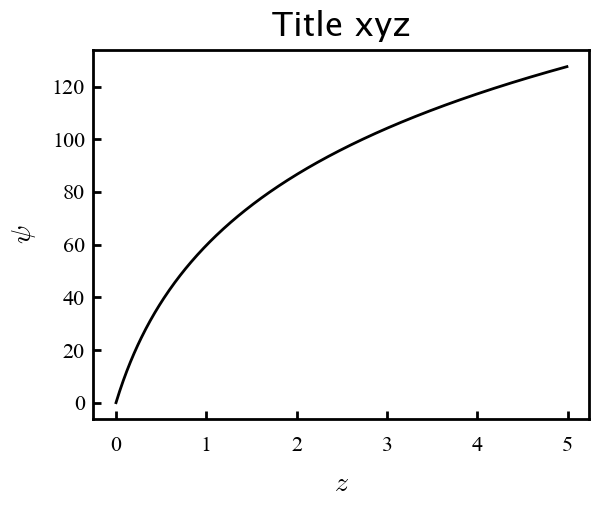

In [4]:
# Analytical, compare with 'soft condensed matter...' textbook, andelman chapter
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*298, 1.6e-19
A = 1

surf_c = -e/2e-09 # C/nm2

lGC = 2*eps0*epsw*kBT/e/abs(surf_c)
psi0 = -2*np.log(lGC)
print(kBT/e)

psi = lambda z: 2*np.log(z+lGC)+psi0
z = np.arange(0,5,0.01)
plt.plot(z, psi(z)*25.7, 'k')

plt.title('Title xyz')
plt.ylabel(r'$\psi$')
plt.xlabel(r'$z$')
tjy.ticks()

# PREV

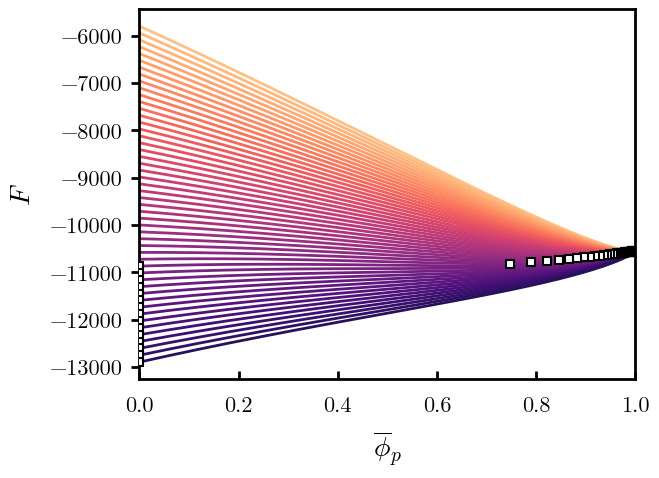

In [2]:
mcs = mpl.colormaps['magma'].resampled(70)(range(60,0,-1))
ccycle = iter(mcs)

def Solve_SCF(mu_w, n_p, N, V, nu):
    chi = 1.00
    
    phi_p = n_p*N*nu/V
    phi_w = 1-phi_p
    w_w   = mu_w - np.log(phi_w)
    eta   = chi*phi_p - w_w
    w_p   = chi*phi_w - eta
    Q_w   = V/nu * np.exp(-w_w)
    Q_p   = V/nu * np.exp(-w_p)
    
    f = -np.exp(mu_w)*Q_w - n_p*N*np.log(Q_p) + V/nu*(chi*phi_p*phi_w - w_p*phi_p - w_w*phi_w) #+ np.log(float(np.math.factorial(int(n_p))))
    return phi_p, f

zeros = []
mu_ws = np.arange(3.00, 8.00, 0.10)
for mu_w in mu_ws:
    N, V, nu = 50, 100, 0.069 # [1], [nm3], [nm3]

    phi_ps, fs = [], []
    for n_p in np.arange(0,V/(nu*N),0.05):
        phi_p, f = Solve_SCF(mu_w, n_p, N, V, nu)
        phi_ps.append(phi_p)
        fs.append(f)
    curve = UnivariateSpline(phi_ps, fs, s=1e-04, k=4)
    zero = curve.derivative(1).roots()
    left, right = float(curve(0)), float(curve(1)) # Extremeties
    fil = lambda x: x[np.argmin(curve(x))] # Find location of minimum
    if    zero.size==1: zero = fil([0,1,zero[0]])
    elif  zero.size==2: zero = fil([0,1,zero[0],zero[1]])
    else: zero = fil([0,1])
    zeros.append(zero)

    plt.plot(phi_ps, curve(phi_ps), label='_'+str(mu_w), c=next(ccycle))
    plt.plot(zero, curve(zero), 's', markerfacecolor='white', c='k', zorder=5)

# plt.legend(loc=(1.07,0.05), title=r'$\mu_w$', title_fontsize=20, ncols=2)
plt.xlim(0.0,1.0)
plt.xlabel(r'$\overline{\phi}_p$')
plt.ylabel(r'$F$')
tjy.ticks()

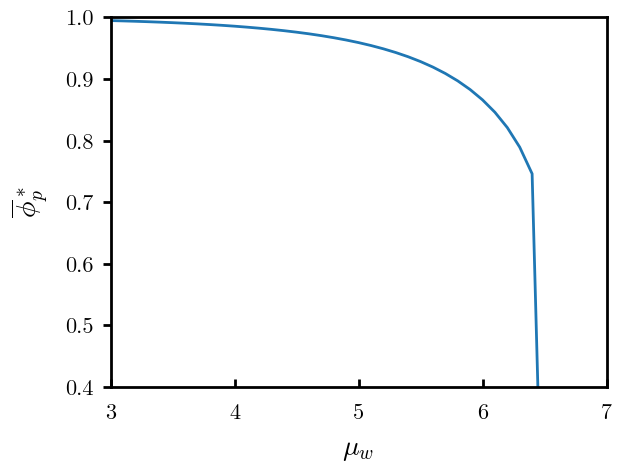

In [4]:
plt.plot(mu_ws, zeros)

plt.ylim(0.4,1)
plt.xlim(3.00, 7.00)
plt.xlabel(r'$\mu_w$')
plt.ylabel(r'$\overline{\phi}_p^*$')
tjy.ticks()

In [2]:
def Process(fname):
    data = pd.read_csv(fname, names=np.arange(12), sep='\s+')
    thetas, nd = [], []
    for i in range(len(data)):
        if i%2: thetas += [data.iloc[i,5]] # Vol dens of block 2 adj. to surf
        else:   nd += [data.iloc[i,:6].to_list()]
    return pd.concat([pd.DataFrame(nd,  columns=['it', 'lx', 'free', 'freeDiff', 'inCompMax', 'andErr']), pd.Series(thetas, name='theta')], axis=1)

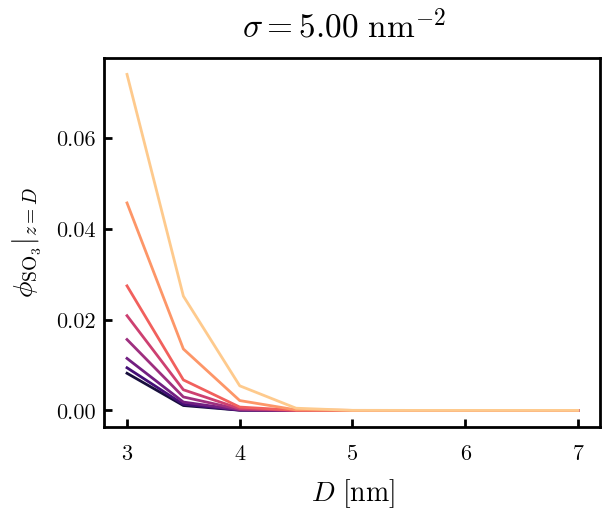

In [23]:
lx30, lx35, lx40, lx45 = Process(GIT+'s500_lx30.txt'), Process(GIT+'s500_lx35.txt'), Process(GIT+'s500_lx40.txt'), Process(GIT+'s500_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s500_lx50.txt'), Process(GIT+'s500_lx55.txt'), Process(GIT+'s500_lx60.txt'), Process(GIT+'s500_lx65.txt'), Process(GIT+'s500_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

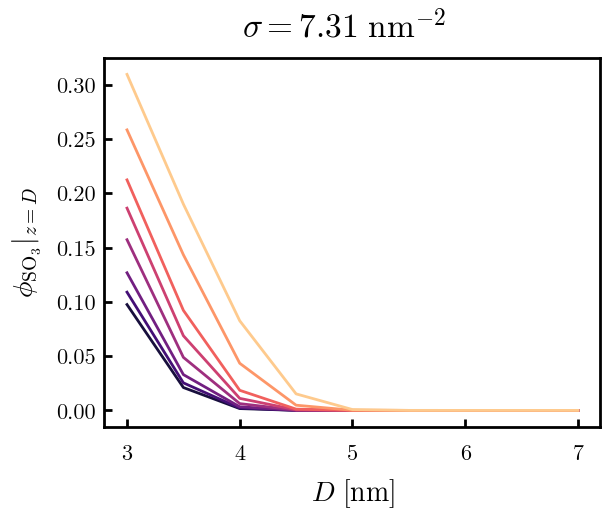

In [22]:
lx30, lx35, lx40, lx45 = Process(GIT+'s731_lx30.txt'), Process(GIT+'s731_lx35.txt'), Process(GIT+'s731_lx40.txt'), Process(GIT+'s731_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s731_lx50.txt'), Process(GIT+'s731_lx55.txt'), Process(GIT+'s731_lx60.txt'), Process(GIT+'s731_lx65.txt'), Process(GIT+'s731_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

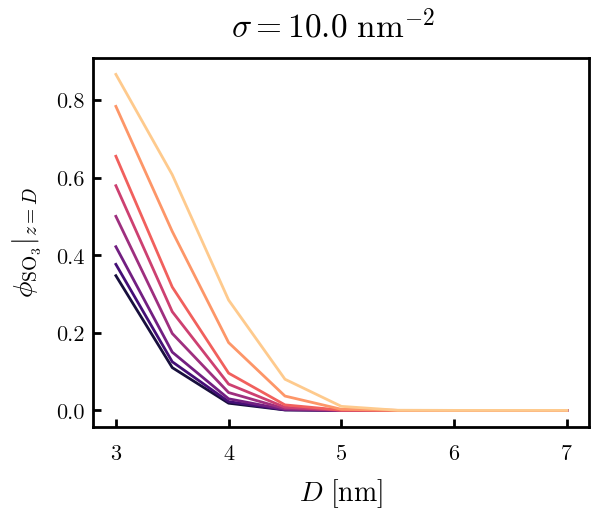

In [21]:
lx30, lx35, lx40, lx45 = Process(GIT+'s1000_lx30.txt'), Process(GIT+'s1000_lx35.txt'), Process(GIT+'s1000_lx40.txt'), Process(GIT+'s1000_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s1000_lx50.txt'), Process(GIT+'s1000_lx55.txt'), Process(GIT+'s1000_lx60.txt'), Process(GIT+'s1000_lx65.txt'), Process(GIT+'s1000_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

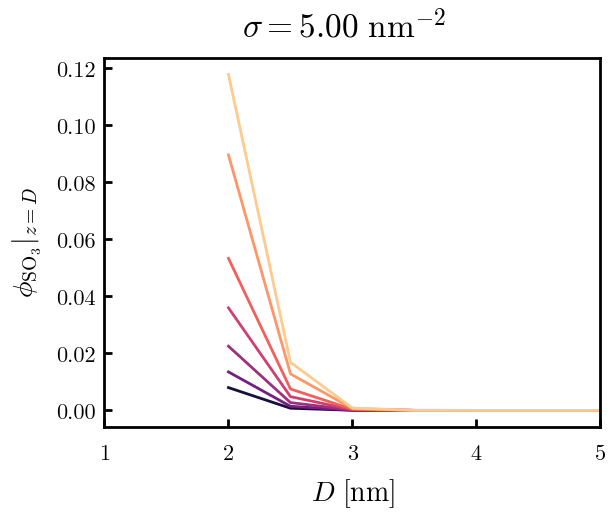

In [45]:
cs = 'c100_'
ss = 's500_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim = (1, 5)
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

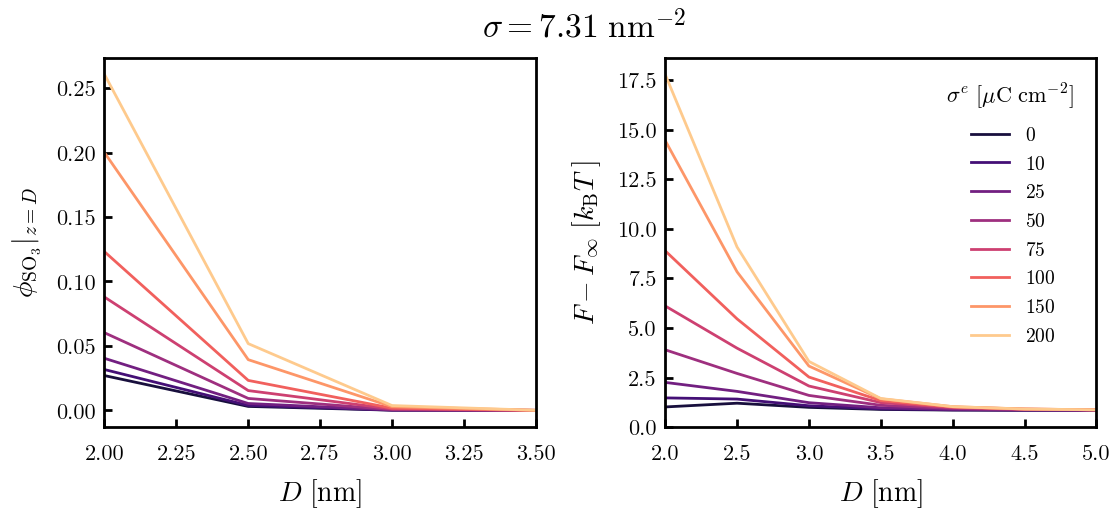

In [187]:
cs,cbulk = 'c100_', 0.1 * 1000 * 6.02e23 / 1e27 *2
ss = 's731_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,2, figsize=(mpl.rcParams['figure.figsize'][0]*2, mpl.rcParams['figure.figsize'][1]))
# ax = [ax]
plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = np.array([i.lx[0] for i in lxs])
    y = [i.free[ind] for i in lxs]
    ax[1].plot(x, y-y[-1] + cbulk*x, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim= (2, 3.5)
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
ax[1].legend(loc=(0.69,0.20), ncol=1)

ax[1].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlim= (2, 5)
)
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

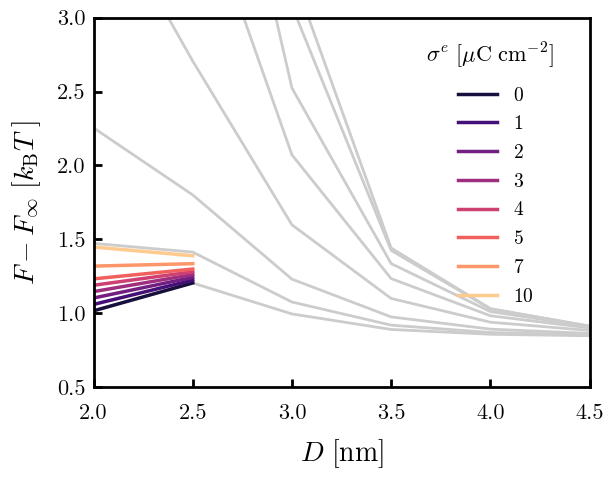

In [127]:
bulk = lx70
for ind,i in enumerate(surfs):
    x = np.array([i.lx[0] for i in lxs])
    y = [i.free[ind] for i in lxs]
    plt.plot(x, y-bulk.free[ind] + cbulk*x, label='_${}$'.format(i), color='0.8')
    
kws = {'names':['it', 'lx', 'free', 'x', 'xx', 'xxx'], 'sep':'\s+'}
data = pd.read_csv(GIT+'new-lx15.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')
data1= pd.read_csv(GIT+'new-lx20.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')
data2= pd.read_csv(GIT+'new-lx25.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')

for ind,i in enumerate([0,1,2,3,4,5,7,10]):
    x=np.array([i.lx[0] for i in [data, data1, data2]])[1:3]
    y=[i.free[ind] for i in [data,data1,data2]][1:3]
    plt.plot(x,y-bulk.free[0]+cbulk*x, label='${}$'.format(i), color=mcs[ind], marker='', lw=2.5)
    
plt.gca().set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlim=(2,4.5),
    ylim=(0.5,3)
)
plt.text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=plt.gca().transAxes, fontsize=16, ha='center')
plt.legend(loc=(0.72,0.2))
tjy.ticks()

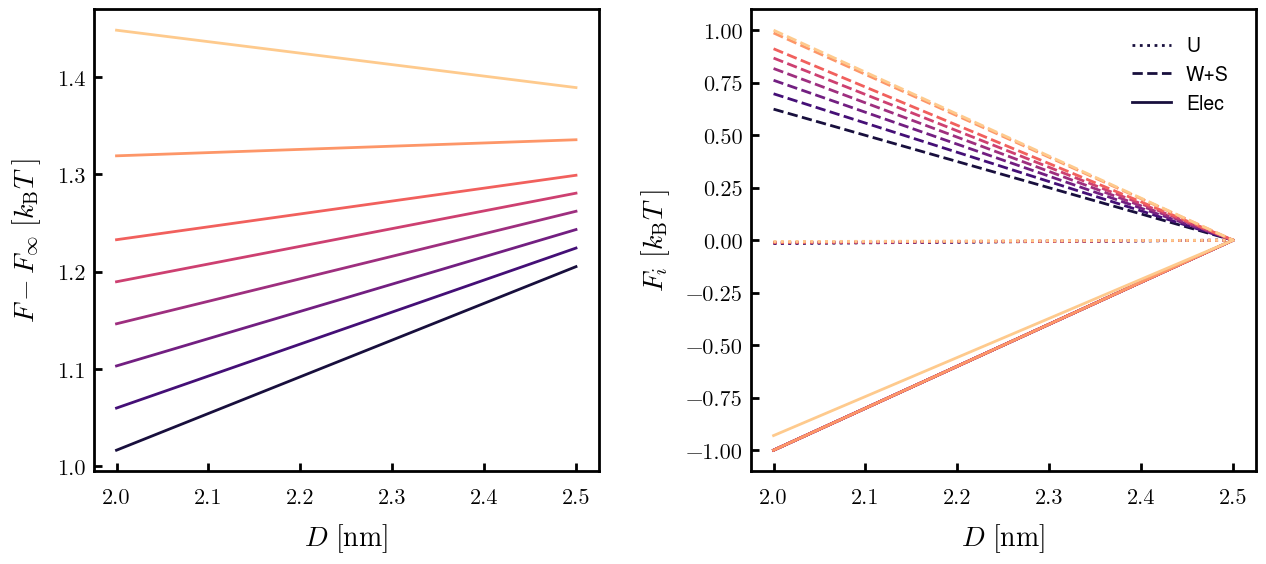

In [185]:
lx25fs = pd.DataFrame([
    [0,  2.500e+00, -4.70644e+01, 1.42445e-01, -5.70074e+01, -1.00664e+01, 2.01681e+01, -3.01100e-01],
    [1,  2.500e+00, -4.70453e+01, 1.42697e-01, -5.69071e+01, -1.01076e+01, 2.01279e+01, -3.01100e-01],
    [2,  2.500e+00, -4.70263e+01, 1.42951e-01, -5.68055e+01, -1.01494e+01, 2.00867e+01, -3.01100e-01],
    [3,  2.500e+00, -4.70075e+01, 1.43208e-01, -5.67026e+01, -1.01915e+01, 2.00445e+01, -3.01100e-01],
    [4,  2.500e+00, -4.69889e+01, 1.43469e-01, -5.65984e+01, -1.02342e+01, 2.00013e+01, -3.01100e-01],
    [5,  2.500e+00, -4.69705e+01, 1.43732e-01, -5.64929e+01, -1.02772e+01, 1.99570e+01, -3.01100e-01],
    [7,  2.500e+00, -4.69340e+01, 1.44269e-01, -5.62778e+01, -1.03647e+01, 1.98653e+01, -3.01100e-01],
    [10, 2.500e+00, -4.68804e+01, 1.45097e-01, -5.59451e+01, -1.04994e+01, 1.97200e+01, -3.01100e-01],
], columns=['surf', 'lx', 'free', 'U', 'W', 'S', 'elec', 'bulk'])
lx20fs = pd.DataFrame([
    [0,  2.000e+00, -4.71928e+01, 1.34811e-01, -7.39004e+01, 7.12726e+00, 1.96863e+01, -2.40880e-01],
    [1,  2.000e+00, -4.71495e+01, 1.35207e-01, -7.36954e+01, 7.04242e+00, 1.96091e+01, -2.40880e-01],
    [2,  2.000e+00, -4.71062e+01, 1.35607e-01, -7.34882e+01, 6.95684e+00, 1.95305e+01, -2.40880e-01],
    [3,  2.000e+00, -4.70629e+01, 1.36010e-01, -7.32789e+01, 6.87055e+00, 1.94503e+01, -2.40880e-01],
    [4,  2.000e+00, -4.70197e+01, 1.36418e-01, -7.30675e+01, 6.78354e+00, 1.93687e+01, -2.40880e-01],
    [5,  2.000e+00, -4.69765e+01, 1.36829e-01, -7.28539e+01, 6.69581e+00, 1.92856e+01, -2.40880e-01],
    [7,  2.000e+00, -4.68903e+01, 1.37662e-01, -7.24202e+01, 6.51825e+00, 1.91149e+01, -2.40880e-01],
    [10, 2.000e+00, -4.67612e+01, 1.38939e-01, -7.17533e+01, 6.24658e+00, 1.88475e+01, -2.40880e-01], 
], columns=['surf', 'lx', 'free', 'U', 'W', 'S', 'elec', 'bulk'])

lxfs = [lx20fs, lx25fs]
end = 1
rel = lambda x: np.array(x) - x[end]
fig, axs = plt.subplots(1,2, figsize=(15, 6))
plt.subplots_adjust(wspace=0.3)
for ind,i in enumerate(lx25fs.surf):
    x = [i.lx[0] for i in lxfs]
    y0= [i.free[ind]-i.bulk[ind]-bulk.free[0] for i in lxfs]
    axs[0].plot(x,y0, label='${}$'.format(i), color=mcs[ind])
    
    rU, rWS, rE = rel([i.U[ind] for i in lxfs]), rel([i.W[ind]+i.S[ind] for i in lxfs]), rel([i.elec[ind] for i in lxfs])
    maxm = np.max([np.max(np.abs(rU)), np.max(np.abs(rWS)), np.max(np.abs(rE))])
    if maxm!=0: 
        axs[1].plot(x,rU/maxm, color=mcs[ind], ls=':', label='U')
        axs[1].plot(x,rWS/maxm,color=mcs[ind], ls='--', label='W+S')
        axs[1].plot(x,rE/maxm, color=mcs[ind], label='Elec')
    
axs[0].set(
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlabel=r'$D\ [\mathrm{nm}]$'
)
axs[1].set(
    ylim=(-1.1,1.1),
    ylabel=r'$F_i\ [k_\mathrm{B}T\ ]$',
    xlabel=r'$D\ [\mathrm{nm}]$'
)
h, l = axs[1].get_legend_handles_labels()
axs[1].legend(handles=h[:3], labels=l[:3])
tjy.ticks(axs)

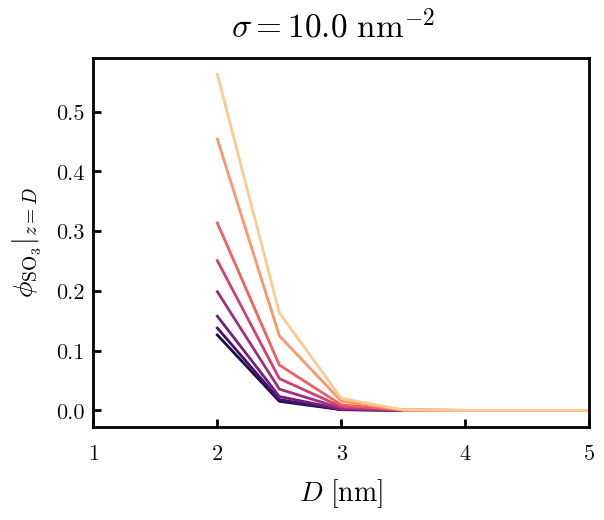

In [48]:
cs = 'c100_'
ss = 's1000_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim= (1, 5),
    # yscale= 'log',
    # ylim= (1e-03, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

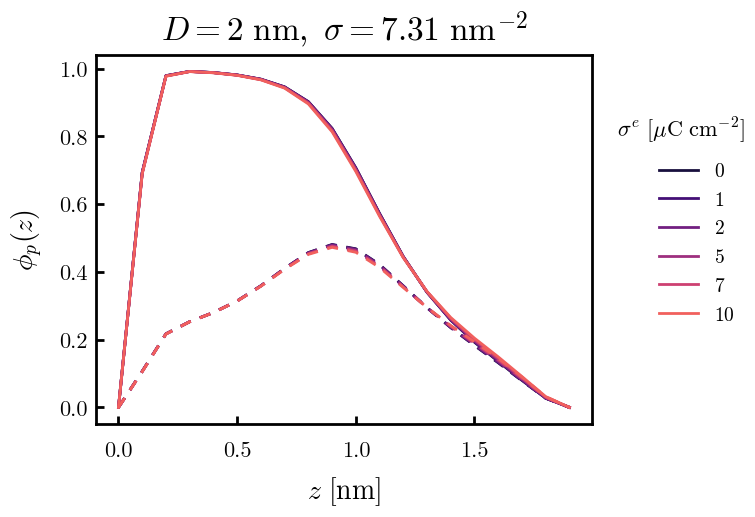

In [93]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'ph_new-lx200e'

fig, ax = plt.subplots(1,1)
for i,c in zip(['000', '001', '002', '005', '007', '010'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
    
# ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
# ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    # xlim= (1.4, 1.8),
    # ylim= (0, 0.30),
)    

ax.text(1.18, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.12,0.25), ncol=1)

plt.title(r'$D=2\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks()

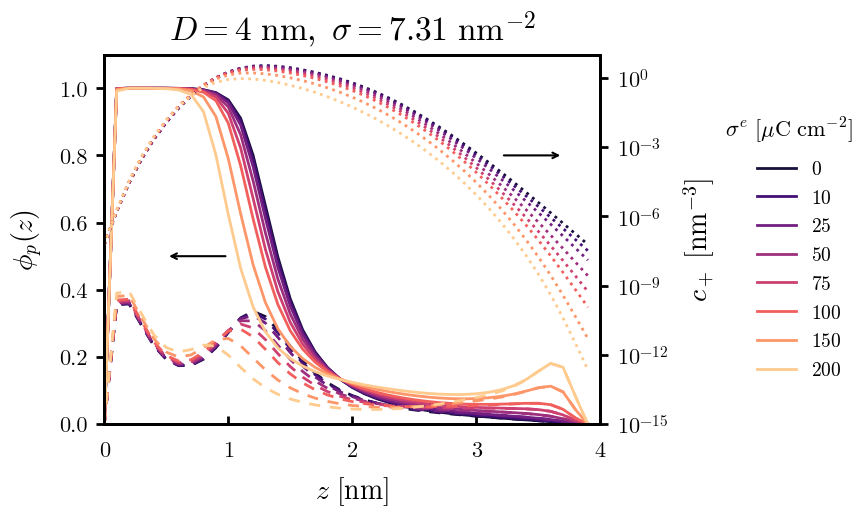

In [3]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731_lx400e'
eat = 'els731_lx400e'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+'.dat')
    rax.plot(el.z, el.an,c=c, ls=':')
    
ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (0, 4),
    ylim= (0, 1.10),
)    
rax.set(
    yscale='log',
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (1e-15, 1e1)
)
ax.text(1.38, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.10), ncol=1)

plt.title(r'$D=4\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks([ax, rax])

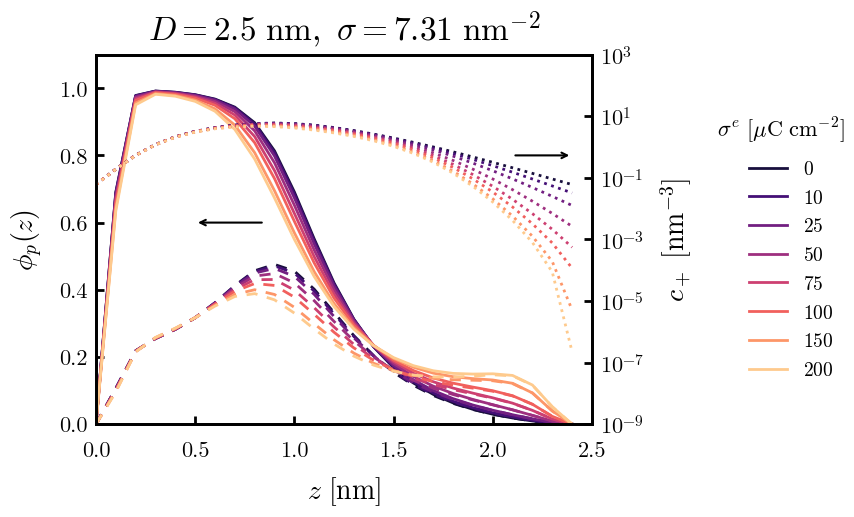

In [77]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731c100_lx250e'
eat = 'els731c100_lx250e'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+'.dat')
    rax.plot(el.z, el.an,c=c, ls=':')
    
ax.annotate("", xy=(0.50, 0.6), xytext=(0.85, 0.6),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.annotate("", xy=(2.4, 0.8), xytext=(2.1, 0.8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (0, 2.5),
    ylim= (0, 1.10),
)    
rax.set(
    yscale='log',
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (1e-9, 1e3)
)
ax.text(1.38, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.10), ncol=1)

plt.title(r'$D=2.5\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks([ax, rax])